# AirBnb Price Prediction - Price Prediction Model
### Part 2/3

In the previous notebook, we cleaned the dataset in order to transform all the features in a way that they can be used to train a machine learning model. Now, let's do some feature selection to understand what are the most descriptive features and finally train the model.

### Dependencies, Libraries and Tools

In [1]:
# Install Spark and related dependencies
!pip install pyspark 

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                set("spark.executor.extraJavaOptions", "-XX:+UseG1GC").\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=624d5f2bf98417a9efde4cd045df0aab1d7232a735fde594f8745a756c65fead
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
# Install and configure ngrok
!pip install pyngrok
!ngrok authtoken 2PHrKeMkk5mvdVY3dhwpeV11UP5_7tfznbJvx6L1DSvj8YD5M

# Import ngrok
from pyngrok import ngrok

# Open a ngrok tunnel on the port 4050 where Spark is running
port = '4050'
public_url = ngrok.connect(port).public_url

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=0bb9780fd0e28a770d27054117d54515257ba07dd55587279a6080574a0ac5b3
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [3]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://7685-35-237-253-59.ngrok-free.app" -> "http://127.0.0.1:4050"


In [4]:
#Install some other useful dependencies
import pandas as pd
import numpy as np
import json

from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

### Link to Google Drive

In [5]:
# Define GDrive paths
GDRIVE_DIR = '/content/drive'
GDRIVE_HOME_DIR = GDRIVE_DIR + '/MyDrive'
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + '/Università/BD-Datasets'

In [6]:
# Point Colaboratory to Google Drive
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


### Dataset

In [7]:
# Define the dataset name in GDrive
gd_df_name = 'airbnb_cleaned_df.csv'

In [8]:
# Read database into a Spark Dataframe
airbnb_df = spark.read.load(GDRIVE_DATA_DIR + '/' + gd_df_name, 
                           format='csv', 
                           sep=',', 
                           inferSchema='true', 
                           header='true')

In [9]:
# Show if dataset was uploaded correctly
airbnb_df.show(n=5, truncate=False)

+------------------+------------------+--------------------+-----------------+-------------------+-------------------------+--------------------+----------------------+----+-------------+---------+------------+--------+----+------------------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+------------------+------------------+------------------+-------------------+-----------------+---------------------+----------------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------+------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+-----------------+-----------------+----------------------+-----------+-----------------

# 5.1 Data Exploration and Feature Selection

In order to analyze the data and create some graphs to better visualize it, I convert the PySpark dataframe to a Pandas one. This step is also useful to select the best features to create the price prediction model.


In [10]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
airbnb_pd = airbnb_df.toPandas() 

In [11]:
# Set some default plotting configuration using seaborn properties
sns.set_style('darkgrid')
sns.set_context('notebook', rc={'lines.linewidth': 2, 
                                'xtick.labelsize': 14, 
                                'ytick.labelsize': 14,
                                'axes.labelsize': 18
                                })

First of all, let's deal with the price. The price is represented by a numerical (continuous) value and it's the target variable (the one we want to predict). Let's visualize the distribution of prices to see if there are some outliers: 

[Text(0, 0.5, 'Price')]

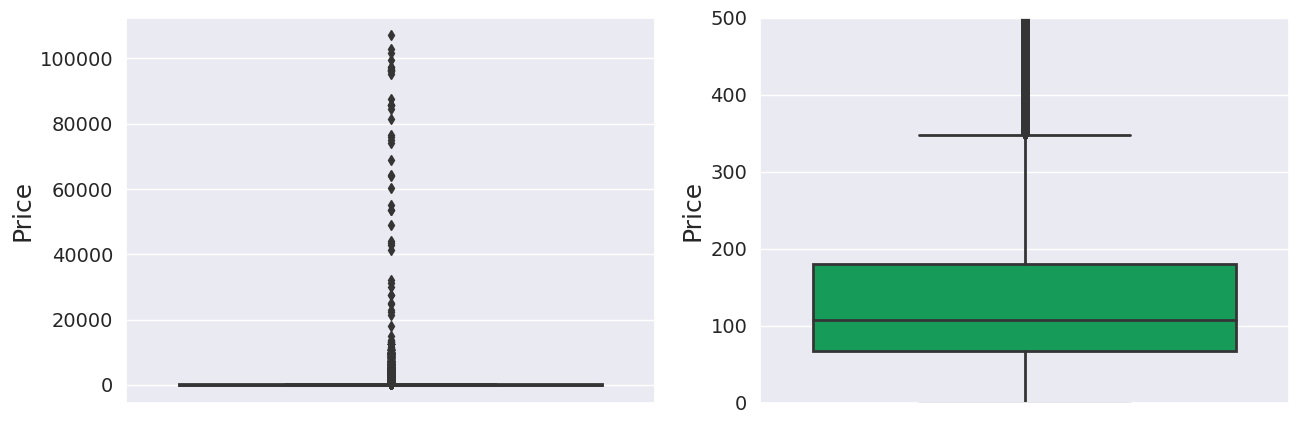

In [12]:
# Price price boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data = airbnb_pd, y = 'price', hue = 'price', color ='#00b159', ax = ax1)
ax1.set(ylabel='Price')
sns.boxplot(data = airbnb_pd, y = 'price', hue = 'price', color ='#00b159', ax = ax2)
ax2.axis(ymin=0,ymax=500)
ax2.set(ylabel='Price')

For the boxplot above it is possible to notice that we have many outliers. Some accommodations have huge prices while others have really low prices. We certainly need to remove the abnormally priced Airbnbs as they are outliers and they could significantly lower the accuracy of the model.

In [13]:
# Calculate the lower and upper bounds for winsorizing
lower_bound = 0.02
upper_bound = 0.98

# Calculate the winsorized values
quantiles = airbnb_df.approxQuantile('price', [lower_bound, upper_bound], 0.01)
lower_quantile = quantiles[0]
upper_quantile = quantiles[1]

# Print quantiles
print("Lower quantile: " + str(lower_quantile))
print("Upper quantile: " + str(upper_quantile))

Lower quantile: 25.68
Upper quantile: 642.0


In [14]:
# Print the number of accomodations the above of below the identified price range
print("The number of Airbnbs with a price smaller than {:d}: ".format(int(lower_quantile)) + str(airbnb_df.select(expr("sum(CASE WHEN price<{:f} THEN 1 ELSE 0 END)".format(lower_quantile))).collect()[0][0]))
print("The number of Airbnbs with a price higher than {:d}: ".format(int(upper_quantile)) + str(airbnb_df.select(expr("sum(CASE WHEN price>{:f} THEN 1 ELSE 0 END)".format(upper_quantile))).collect()[0][0]))

The number of Airbnbs with a price smaller than 25: 5019
The number of Airbnbs with a price higher than 642: 7099


In [15]:
# Remove the Airbnb with a too low (too high) price
airbnb_df = airbnb_df.filter(col('price') > lower_quantile).filter(col('price') < upper_quantile)

In [16]:
# Let's also update the Pandas dataframe so that we keep the two dataframes aligned
airbnb_pd = airbnb_pd[airbnb_pd['price'] > lower_quantile]
airbnb_pd = airbnb_pd[airbnb_pd['price'] < upper_quantile]

In order to reduce the magnitude of the price column, I substitute the price with log(price):

In [17]:
# Compute log(price)
airbnb_df = airbnb_df.withColumn('price', log(airbnb_df['price']))

Now, let's see if there are some correlations among the features and the target variable (price). Let's start by looking at the relationship between host information and the Airbnb price:

In [18]:
# Host information discrete/categorical features
host_information_cat_features = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_response_time', 'is_email_verified', 'is_phone_verified', 'is_work_email_verified']

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

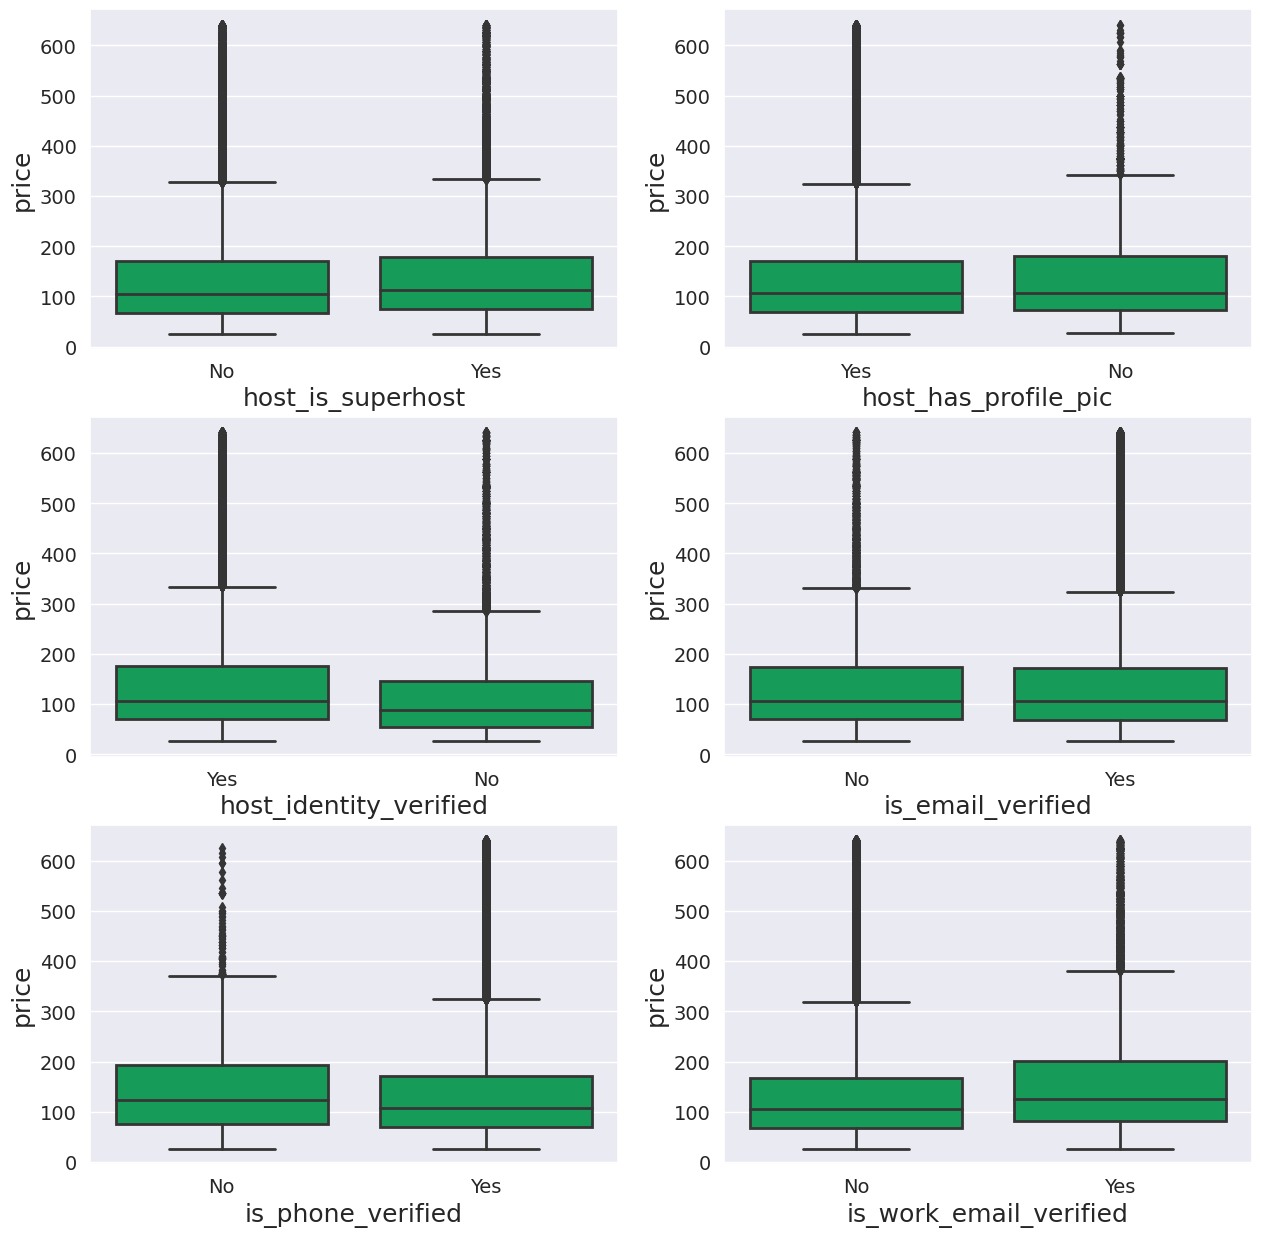

In [19]:
# Host information boxplots (for categorical features)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[0], y = 'price', color ='#00b159', ax = ax1)
ax1.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[1], y = 'price', color ='#00b159', ax = ax2)
ax2.set_xticklabels(['Yes', 'No'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[2], y = 'price', color ='#00b159', ax = ax3)
ax3.set_xticklabels(['Yes', 'No'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[4], y = 'price', color ='#00b159', ax = ax4)
ax4.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[5], y = 'price', color ='#00b159', ax = ax5)
ax5.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[6], y = 'price', color ='#00b159', ax = ax6)
ax6.set_xticklabels(['No', 'Yes'])

[Text(0, 0, 'Within an hour'),
 Text(1, 0, 'Unknown'),
 Text(2, 0, 'Within a few hours'),
 Text(3, 0, 'Within a day'),
 Text(4, 0, 'A few days or more')]

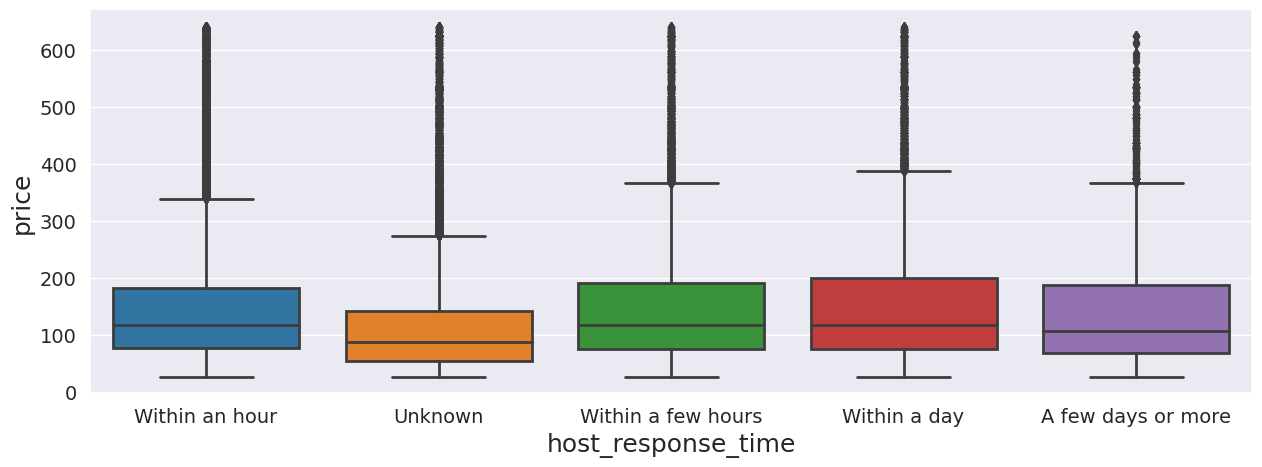

In [20]:
# Host information boxplots (for categorical features - host_response_time)
fig, ax = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[3], y = 'price', ax = ax)
ax.set_xticklabels(['Within an hour', 'Unknown', 'Within a few hours', 'Within a day', 'A few days or more'])

In [21]:
# Host information numerical values
host_information_num_features = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count']

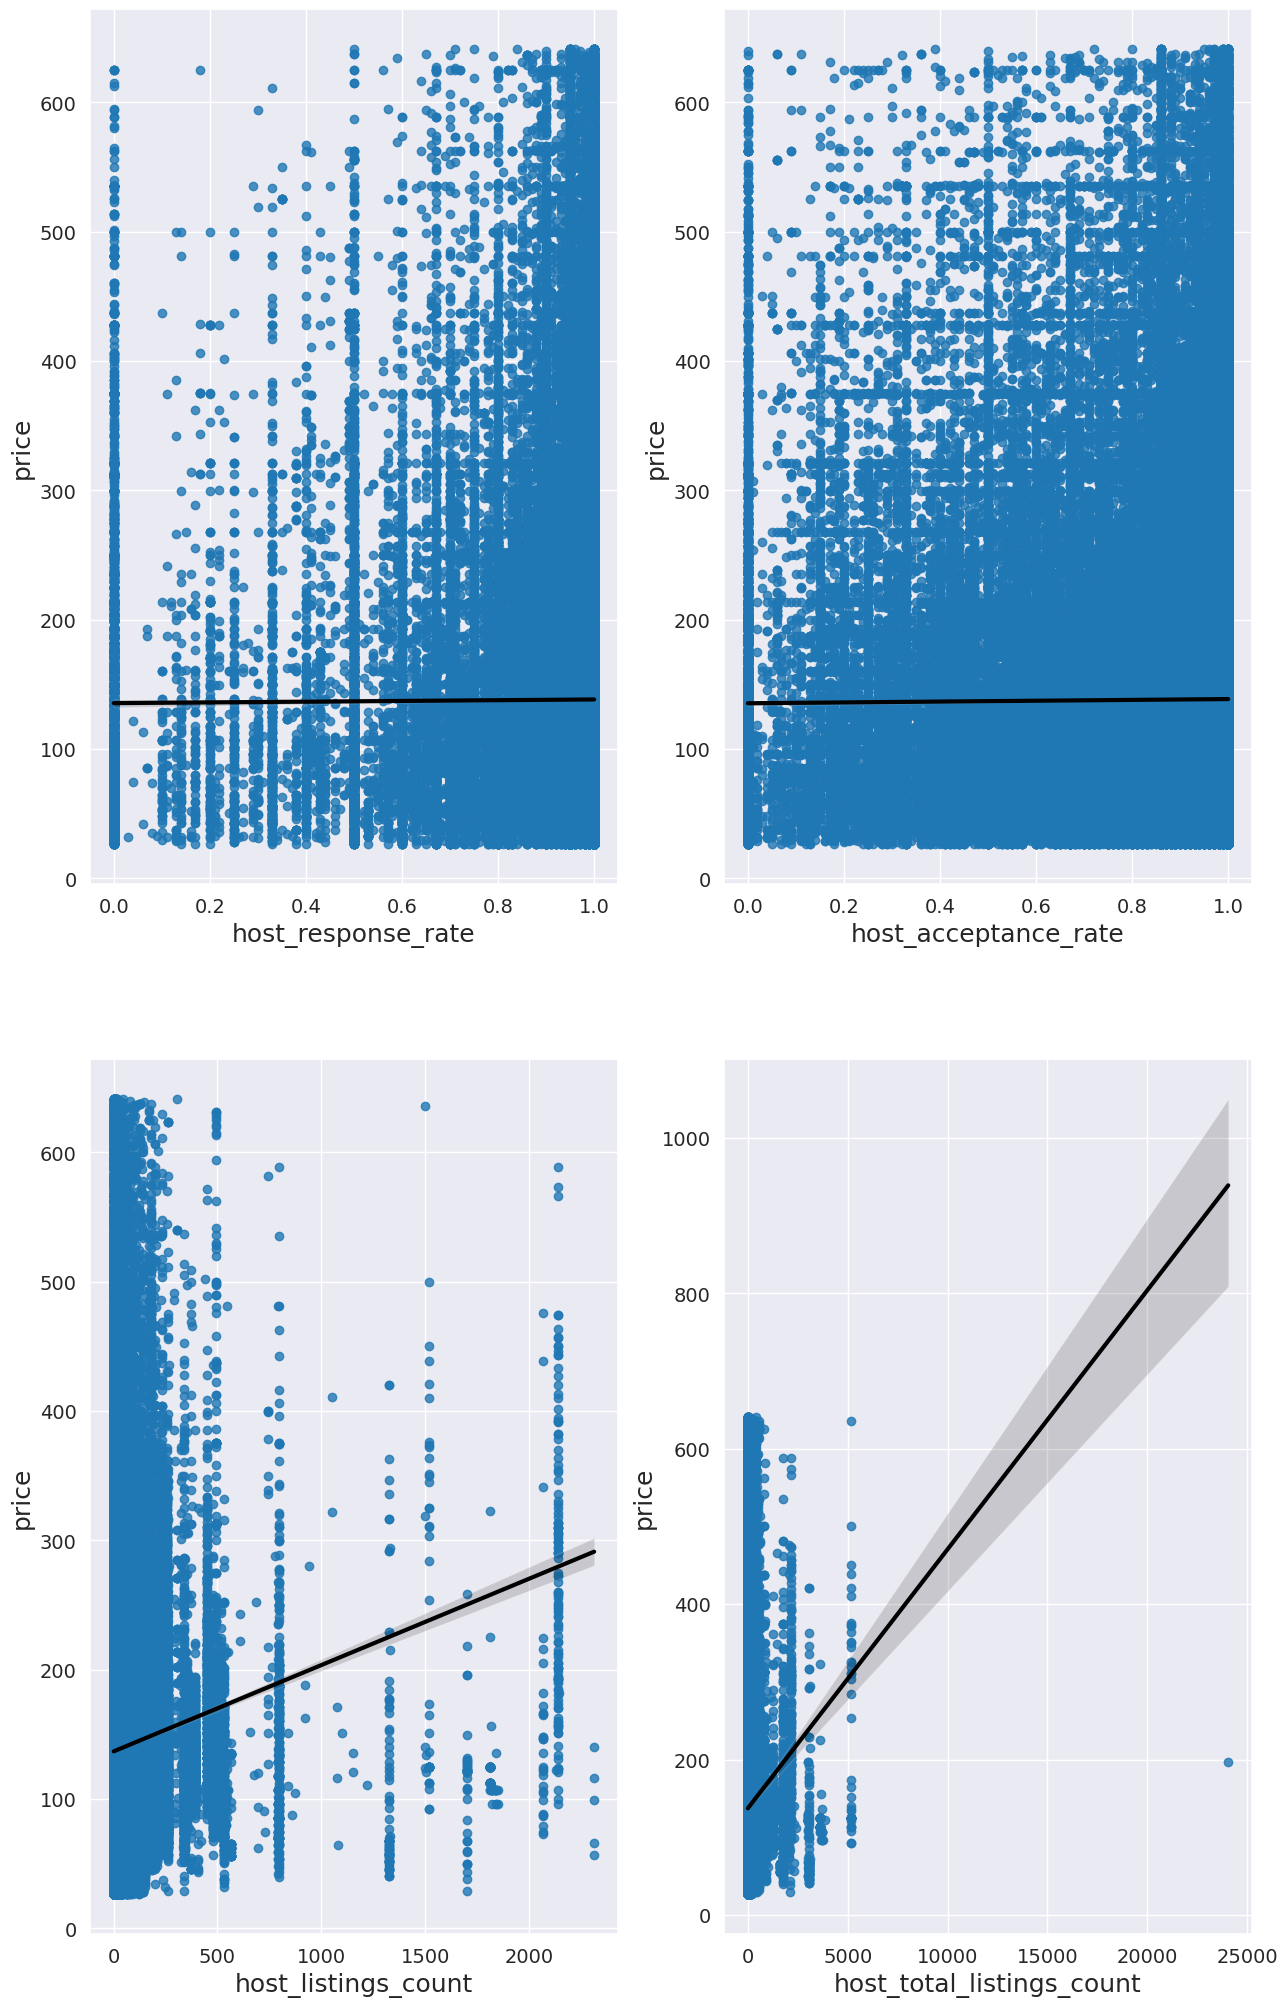

In [22]:
# Host information regplots (for numerical features) to see if they are linearly correlated with the price
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,25))
for i, f in enumerate(host_information_num_features):
  _ = sns.regplot(data = airbnb_pd, x = f, y = 'price', line_kws={'color': 'black'}, ax=axes[i//n_cols, i%n_cols])

In [23]:
# Remove outliers in "host_total_listings_counts"
airbnb_df = airbnb_df.filter(col('price') < 5000)

In [24]:
# Aggregate host information features for correlation analysis
host_information_features = host_information_num_features+host_information_cat_features+['price']

<Axes: >

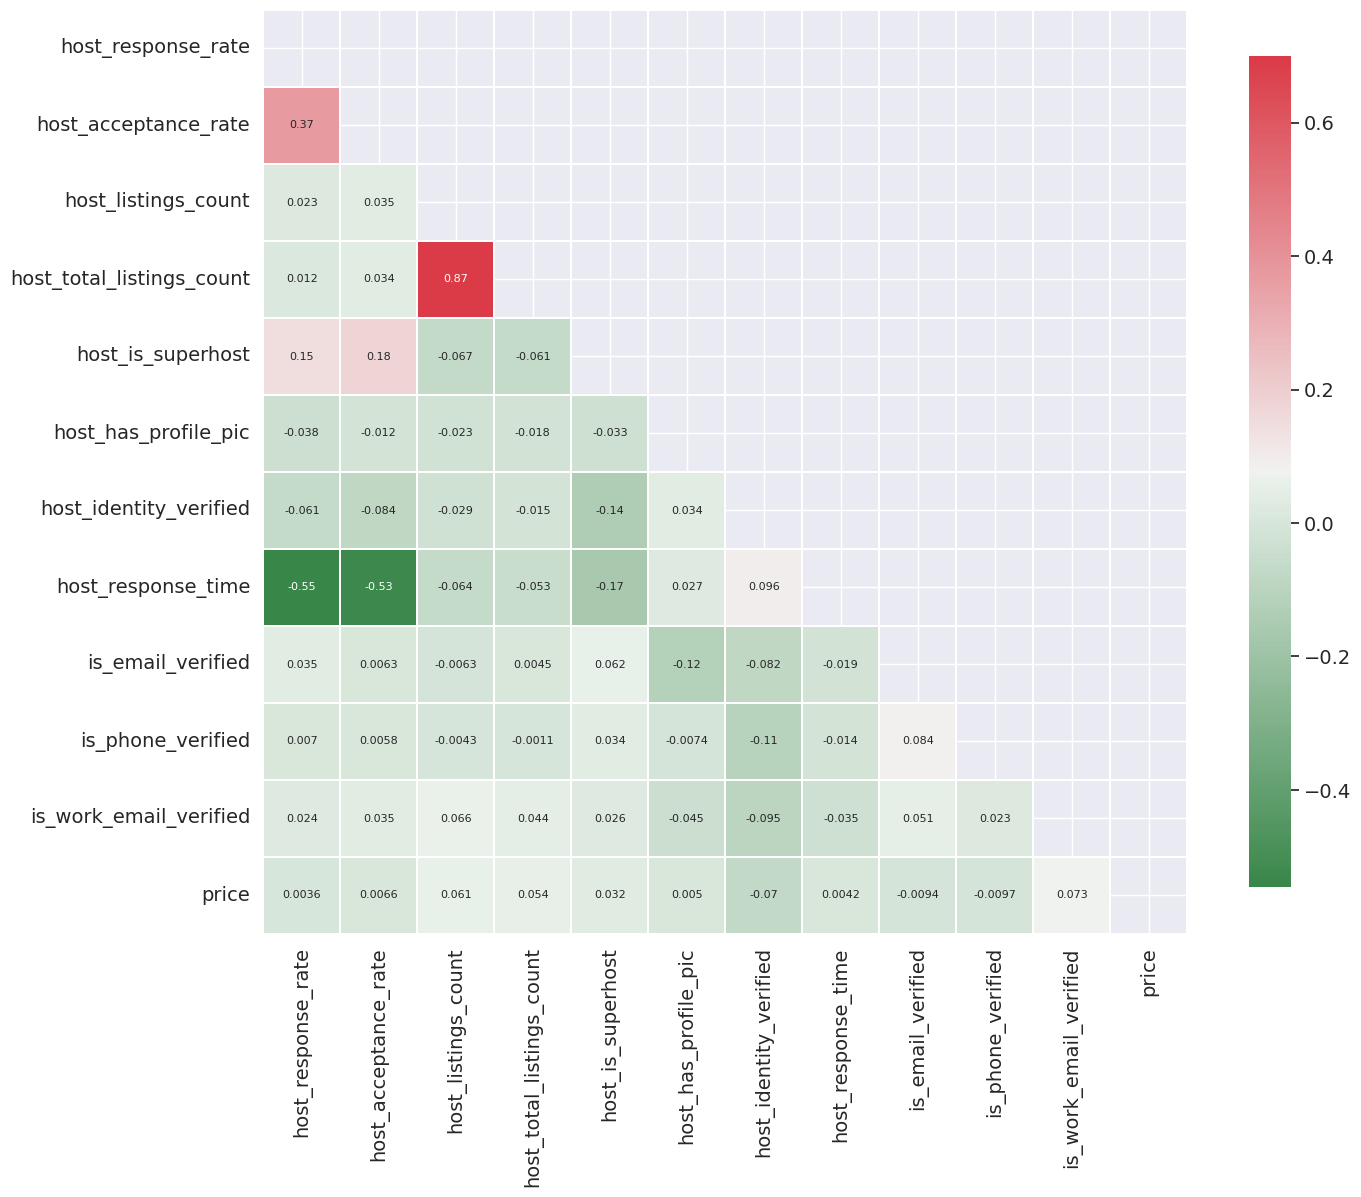

In [25]:
# Correlation between host information features and price
mask = np.zeros_like(airbnb_pd[host_information_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(16, 12))           
sns.heatmap(airbnb_pd[host_information_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

It is immediate to notice that there is no clear correlation between the price and the host information features. We can see that if the host is a superhost, the price slightly increases. If the host doesn't have a profile pic, the price decreases. Now, this last piece of information is not so significant so we can remove it. Host response rate and host response time has a high negative correlation and this is quite surprising, and the first one is also correlated to the host acceptance rate. I only leave the information on the response time since it is the most correlated to the price. Host listings count and total host listing counts are highly correlated as we could expect so we only leave the first one that is more correlated with the price.

In [26]:
# Drop some columns
airbnb_df = airbnb_df.drop('host_response_rate', 'host_acceptance_rate', 'host_total_listings_count', 'host_has_profile_pic')

Now, let's analize the cities and the location information that we have:

In [27]:
# Print the average price of the cities
avg_prices = airbnb_pd.groupby('city')['price'].mean()
print(avg_prices)

city
0     159.107171
1     148.689719
2     138.984889
3     117.872331
4     133.630415
5     135.000786
6     116.418145
7      94.335333
8     104.011934
9      88.125693
10    102.518517
11    162.013627
12    220.234930
13    107.735079
14    136.698567
Name: price, dtype: float64


As we can see, the price changes between the different cities and this might depend on the average cost of life. However, the differences are not huge so we can deal with that without oversampling the dataset. Let's see now if the features on the location information we added before actually helps determining the price of an accommodation:

In [28]:
# Collect names of location features
location_features = ['price', 'station_dist', 'city_center_dist', 'poi_dist']

<Axes: >

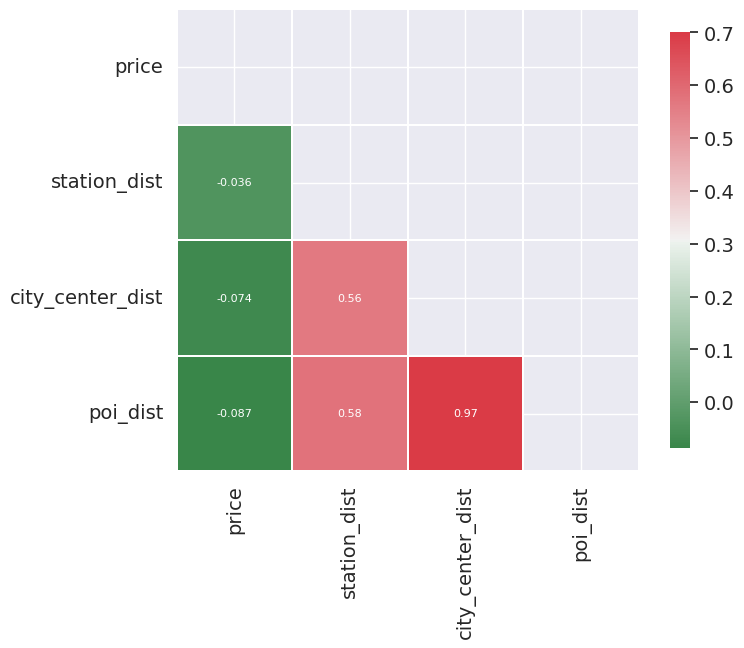

In [29]:
# Correlation between distance features and price
mask = np.zeros_like(airbnb_pd[location_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[location_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

As we can see, all the distances have a negative correlation with the price. This means that as the distance increases, the price decreases and this is really useful information. It is also interesting to notice that city center distance and POI (point of interest) distance are highly correlated. This is probably because most points of interest are near the city center and as we go far away from the city center, also the distances from the POI are lower. For the moment we leave both features and we'll eventually see if leave them both or remove one of the two.

[Text(0, 0, 'London'),
 Text(1, 0, 'Paris'),
 Text(2, 0, 'Rome'),
 Text(3, 0, 'Madrid'),
 Text(4, 0, 'Milan'),
 Text(5, 0, 'Barcelona'),
 Text(6, 0, 'Lisboa'),
 Text(7, 0, 'Vienna'),
 Text(8, 0, 'Berlin'),
 Text(9, 0, 'Athens'),
 Text(10, 0, 'Lyon'),
 Text(11, 0, 'Dublin'),
 Text(12, 0, 'Amsterdam'),
 Text(13, 0, 'Brussels'),
 Text(14, 0, 'Munich')]

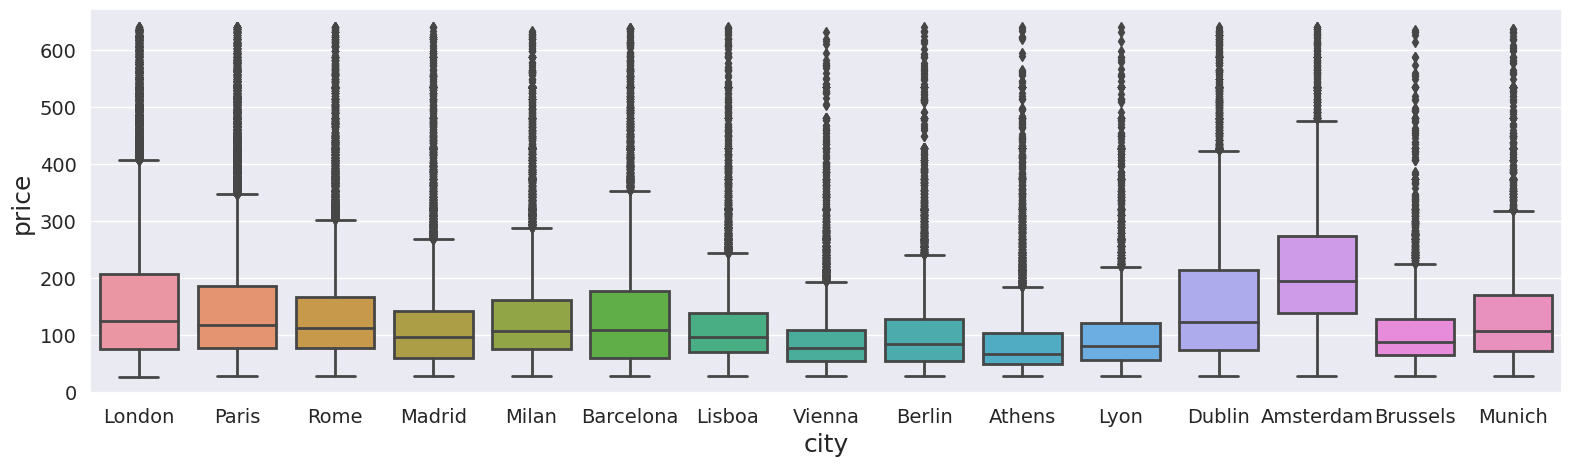

In [30]:
# Plot price distribution among cities
fig, (ax1) = plt.subplots(1, 1, figsize=(19,5))
sns.boxplot(data = airbnb_pd, x = 'city', y = 'price', ax = ax1)
ax1.set_xticklabels(['London', 'Paris', 'Rome', 'Madrid', 'Milan', 'Barcelona', 'Lisboa', 'Vienna', 'Berlin', 'Athens', 'Lyon', 'Dublin', 'Amsterdam', 'Brussels', 'Munich'])

Now, let's see what happens with the accommodation features. Let's analyze if there are some outliers regarding the number of beds, bedrooms and bathrooms:

<Axes: ylabel='n_bathrooms'>

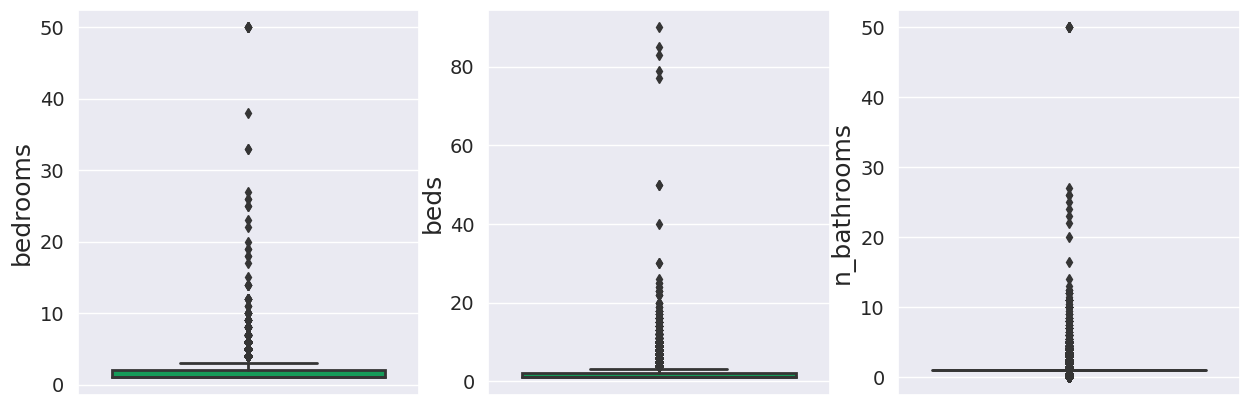

In [31]:
# Outliers analysis for the characteristics of the Airbnb
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(data = airbnb_pd, y = 'bedrooms', hue = 'price', color ='#00b159', ax = ax1)
sns.boxplot(data = airbnb_pd, y = 'beds', hue = 'price', color ='#00b159', ax = ax2)
sns.boxplot(data = airbnb_pd, y = 'n_bathrooms', hue = 'price', color ='#00b159', ax = ax3)

In [32]:
print("The number of Airbnbs with more than 5 bedrooms: " + str(airbnb_df.select(expr("sum(CASE WHEN bedrooms>5 THEN 1 ELSE 0 END)")).collect()[0][0]))
print("The number of Airbnbs with more than 10 beds: " + str(airbnb_df.select(expr("sum(CASE WHEN beds>10 THEN 1 ELSE 0 END)")).collect()[0][0]))
print("The number of Airbnbs with more than 4 bathrooms: " + str(airbnb_df.select(expr("sum(CASE WHEN n_bathrooms>4 THEN 1 ELSE 0 END)")).collect()[0][0]))
print("The number of Airbnbs with more than 10 accommodates: " + str(airbnb_df.select(expr("sum(CASE WHEN accommodates>10 THEN 1 ELSE 0 END)")).collect()[0][0]))

The number of Airbnbs with more than 5 bedrooms: 493
The number of Airbnbs with more than 10 beds: 369
The number of Airbnbs with more than 4 bathrooms: 582
The number of Airbnbs with more than 10 accommodates: 1326


Looking at graphs, it is possible to notice that the number of accommodations with a high number of bedrooms, beds and bathrooms is really low so they are outliers. For this reason I decide to not consider them.

In [33]:
# Remove the number of Airbnbs with a high number of bedrooms/beds/bathrooms
airbnb_df = airbnb_df.filter(col('bedrooms') <= 5).filter(col('beds') <= 10).filter(col('n_bathrooms') <= 4).filter(col('n_bathrooms') <= 10)

In [34]:
# Let's also update the Pandas dataframe so that we keep the two dataframes aligned
airbnb_pd = airbnb_pd[airbnb_pd['bedrooms'] <= 5]
airbnb_pd = airbnb_pd[airbnb_pd['beds'] <= 10]
airbnb_pd = airbnb_pd[airbnb_pd['n_bathrooms'] <= 4]

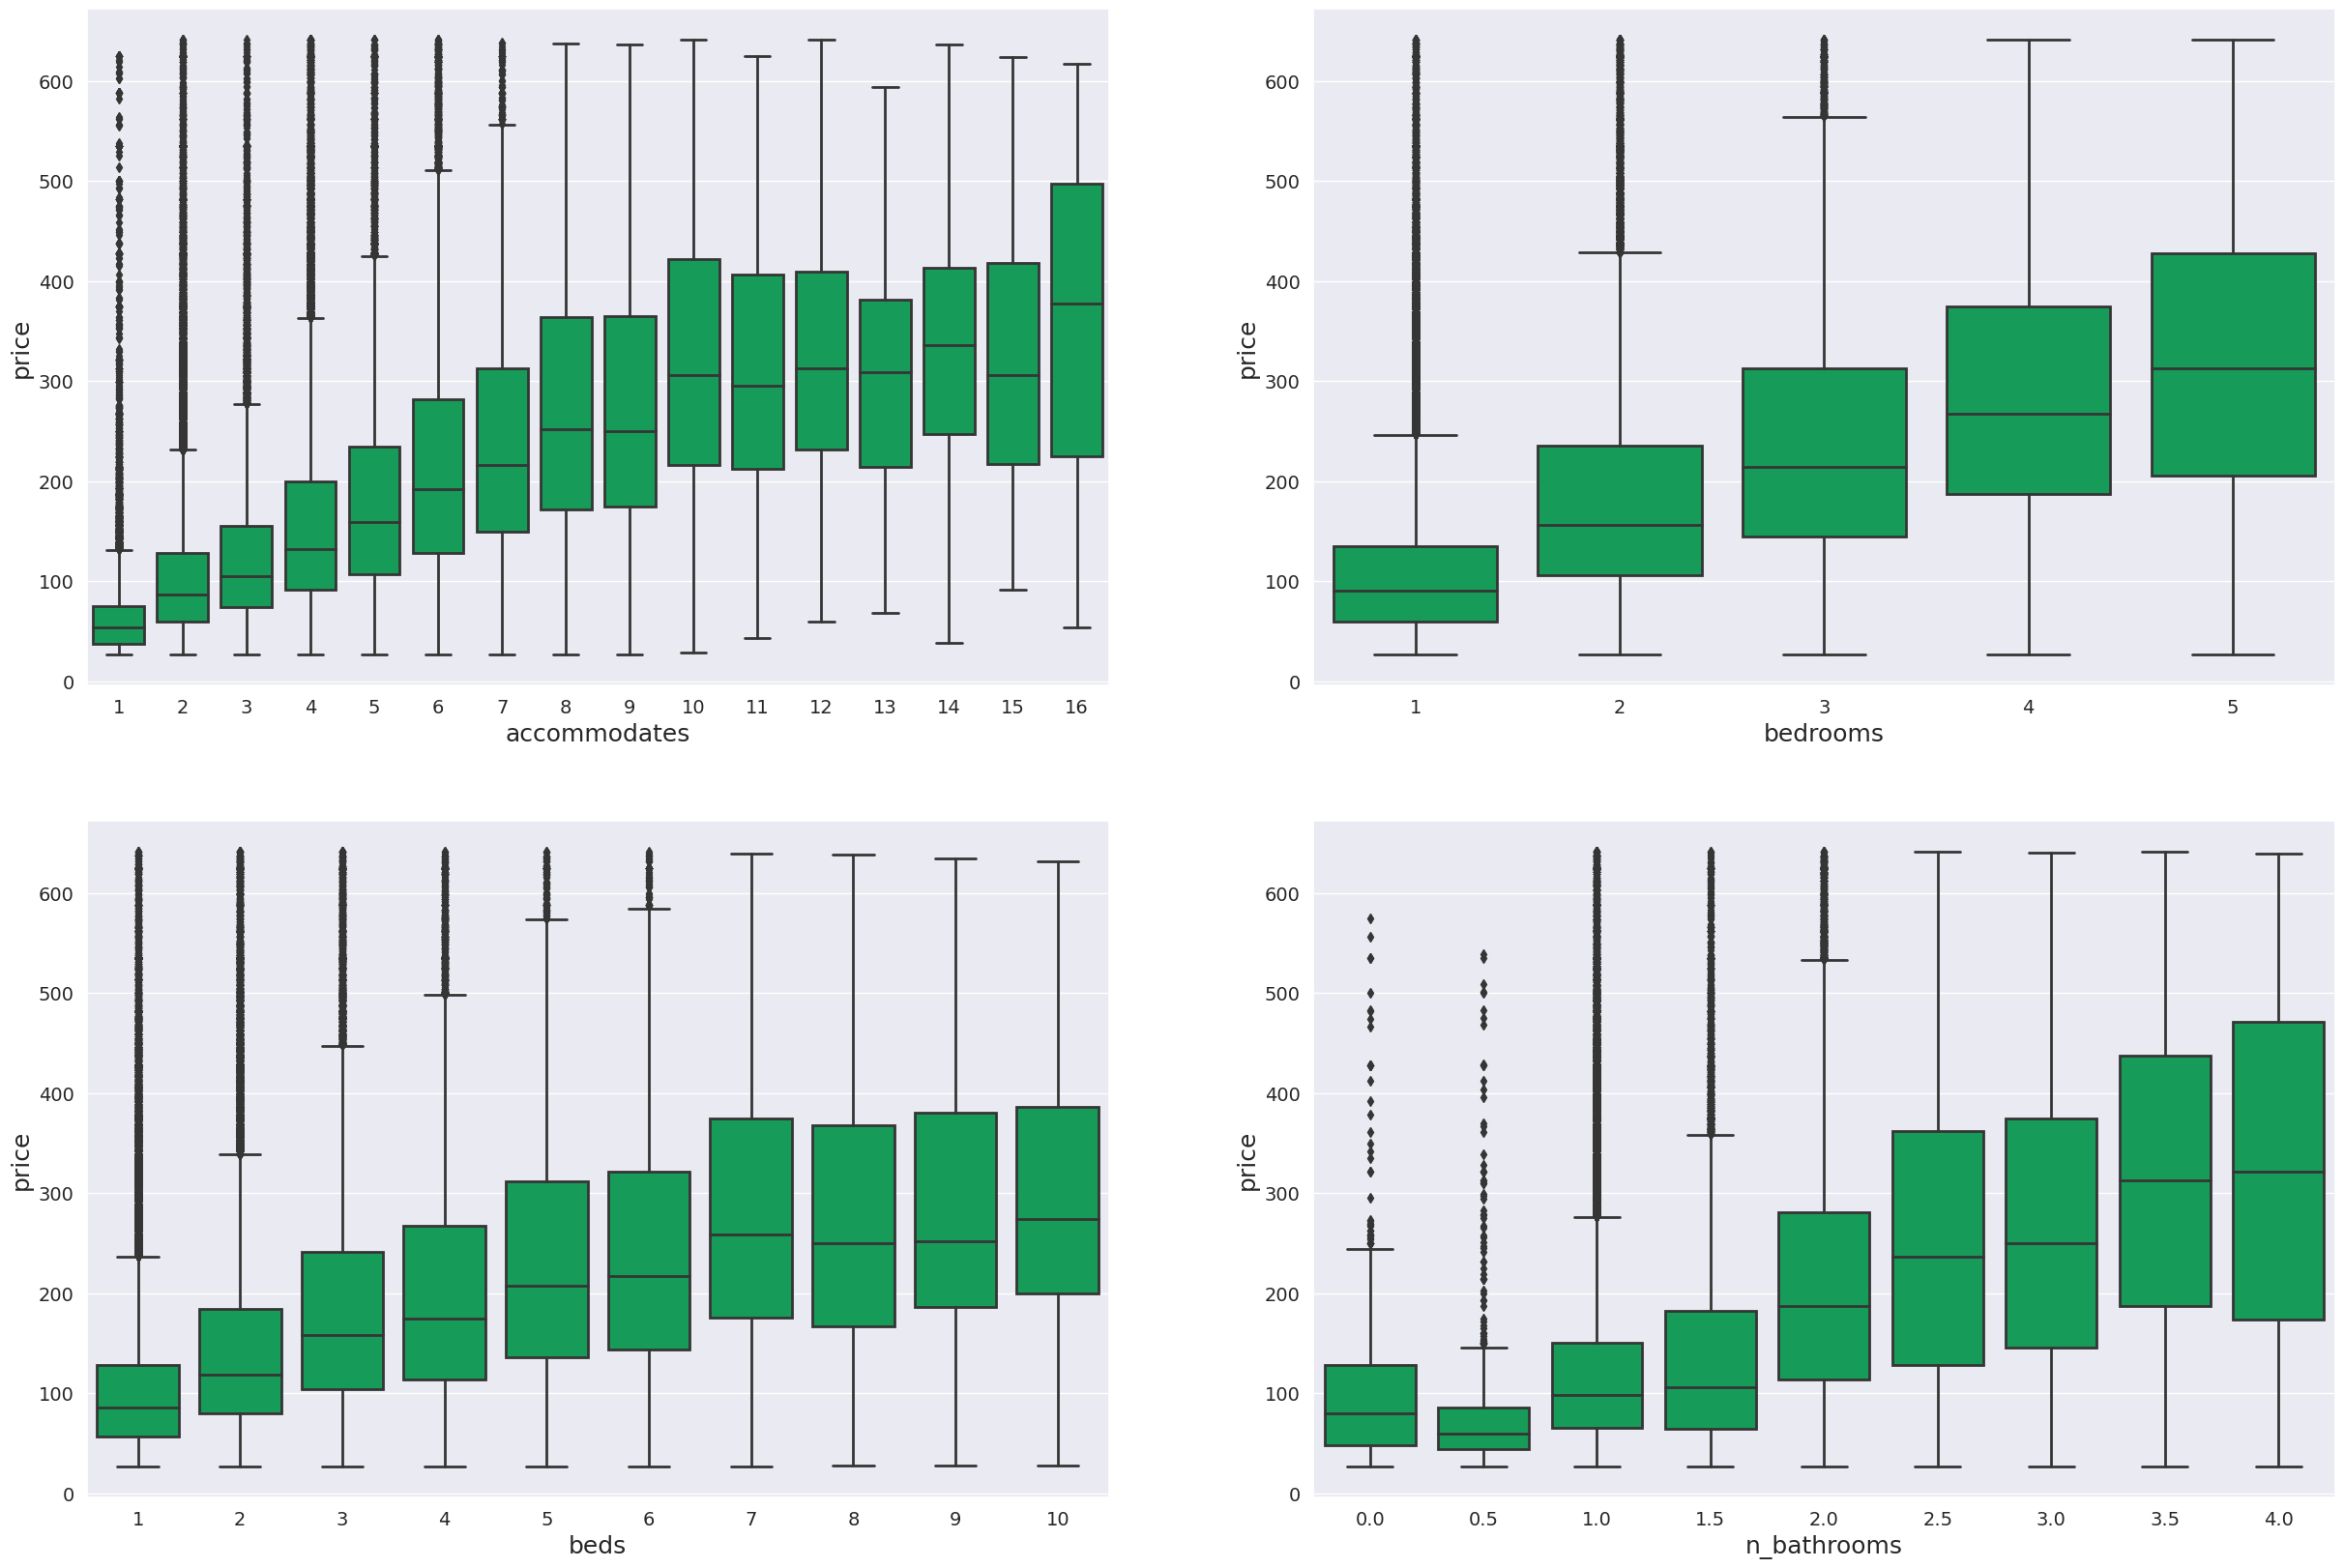

In [35]:
# Visualize the variation of the price changing the characteristics of the Airbnb
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30,20))
for i, f in enumerate(['accommodates', 'bedrooms', 'beds', 'n_bathrooms']):
  _ = sns.boxplot(data = airbnb_pd, x = f, y = "price", color='#00b159', ax=axes[i//n_cols, i%n_cols])

We can notice how the average price arises when we have a larger number of bedrooms, bathrooms and beds (as well as the number of accommodates). This information might be useful when determining the price of Airbnbs. Concerning the bathrooms, let's see if there are differences with the fact that it is shared or not:

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

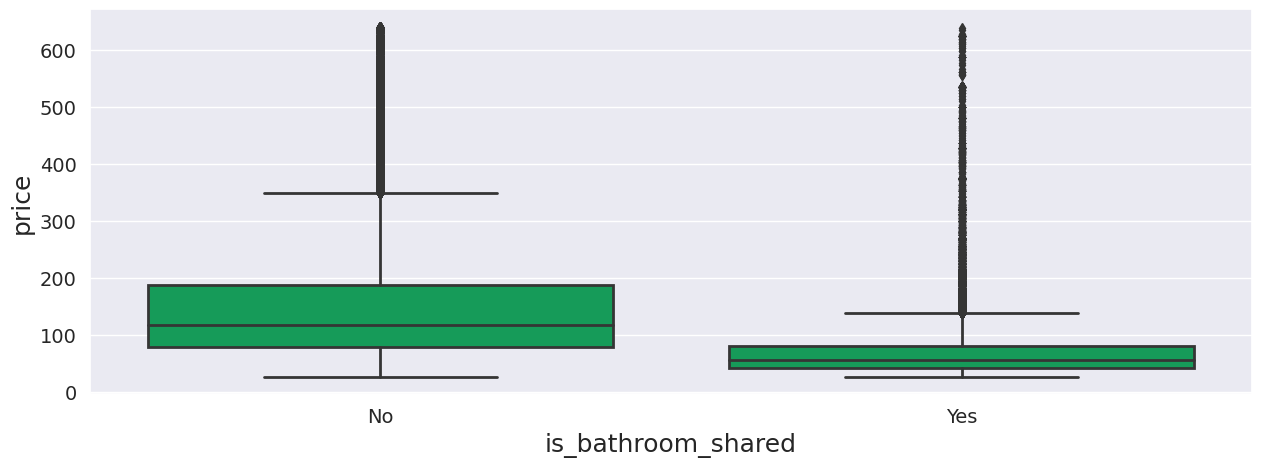

In [36]:
# # Visualize the variation of the price if the bathroom is shared or private
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = 'is_bathroom_shared', y = 'price', color='#00b159', ax=ax1)
ax1.set_xticklabels(['No', 'Yes'])

In [37]:
# Print all unique "is_bathroom shared" in the dataset
airbnb_df.groupBy("is_bathroom_shared").agg(count('*')).show()

+------------------+--------+
|is_bathroom_shared|count(1)|
+------------------+--------+
|                 1|   40978|
|                 0|  240705|
+------------------+--------+



As we could expect, if the bathrooms are shared (not private), the price of the Airbnb drops. Let's see now if there are some differences regarding the type of property:

[Text(0, 0, 'Entire home/apt'),
 Text(1, 0, 'Private room'),
 Text(2, 0, 'Hotel room'),
 Text(3, 0, 'Shared room')]

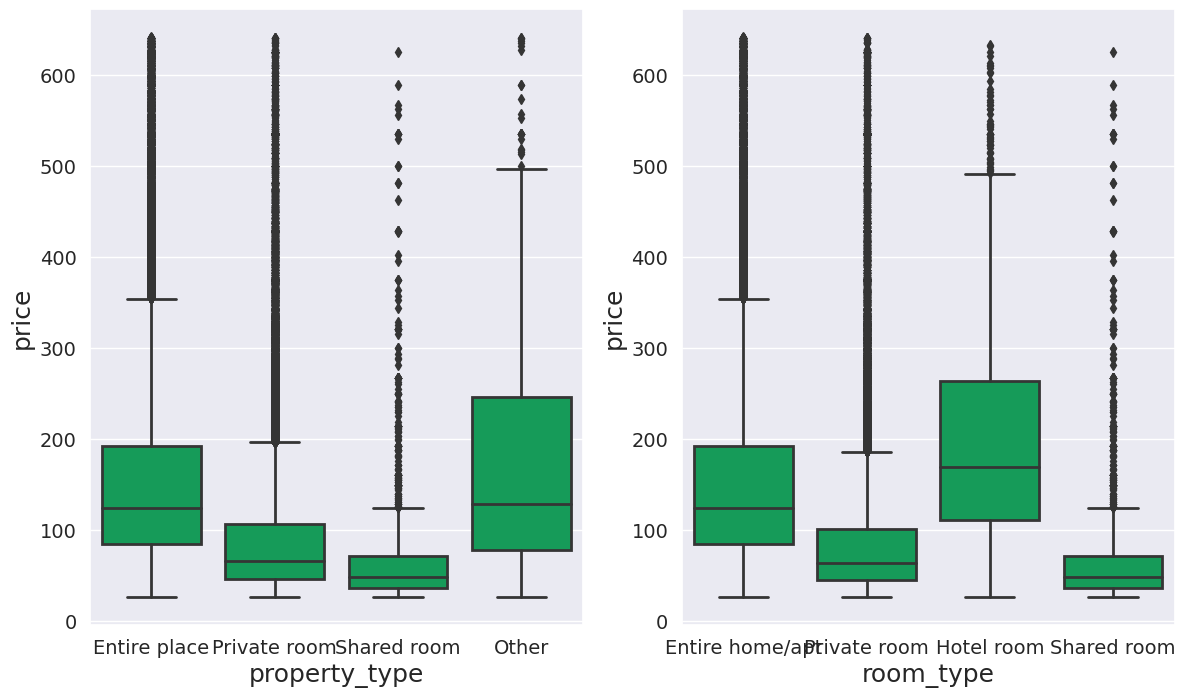

In [38]:
# Visualize the variation of the price changing the room and property type
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))
sns.boxplot(data = airbnb_pd, x = 'property_type', y = 'price', color='#00b159', ax=ax1)
ax1.set_xticklabels(['Entire place', 'Private room', 'Shared room', 'Other'])
sns.boxplot(data = airbnb_pd, x = 'room_type', y = 'price', color='#00b159', ax=ax2)
ax2.set_xticklabels(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'])

Again, as we could expect there are some differences. It is possible to notice that if the room is shared, the price drops. In the "other" properties, the price is higher because they are usually peculiar accommodations (e.g. boat, cave, a whole island, etc..).

In [39]:
# List the features that describe the characteristics of the Airbnb
accomodation_features = ['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'n_bathrooms', 'is_bathroom_shared', 'price']

<Axes: >

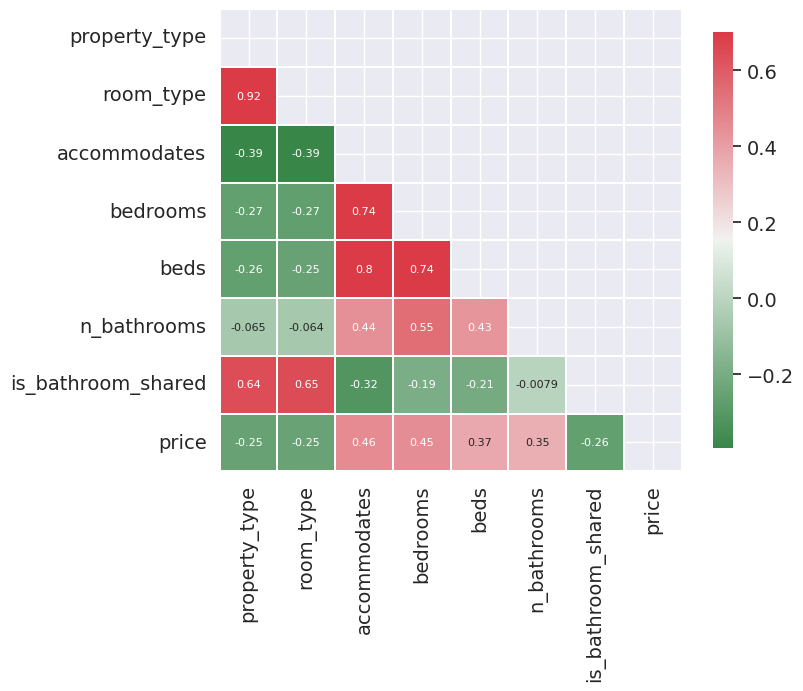

In [40]:
# Correlation between the characteristic features and price
mask = np.zeros_like(airbnb_pd[accomodation_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[accomodation_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

Room type and property type are highly correlated (almost completely) so we can immediatly remove one of them (we keep the room_type as it is able to also describe the property type someway). Also, the number of accommodates, beds and bedrooms are highly correlated (they are all linked to the size of accommodation). We will later see it is convenient to remove some of them.

In [41]:
# Drop some columns
airbnb_df = airbnb_df.drop('property_type')

Now, there are a bunch of features describing the minimum and maximum nights a guest can stay in the Airbnb along with some statistical features (e.g. the average). Let's see if they can help determining the price:

In [42]:
# List the features that describe the minimum/maximum period of stay
period_stay_features = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'price']

<Axes: >

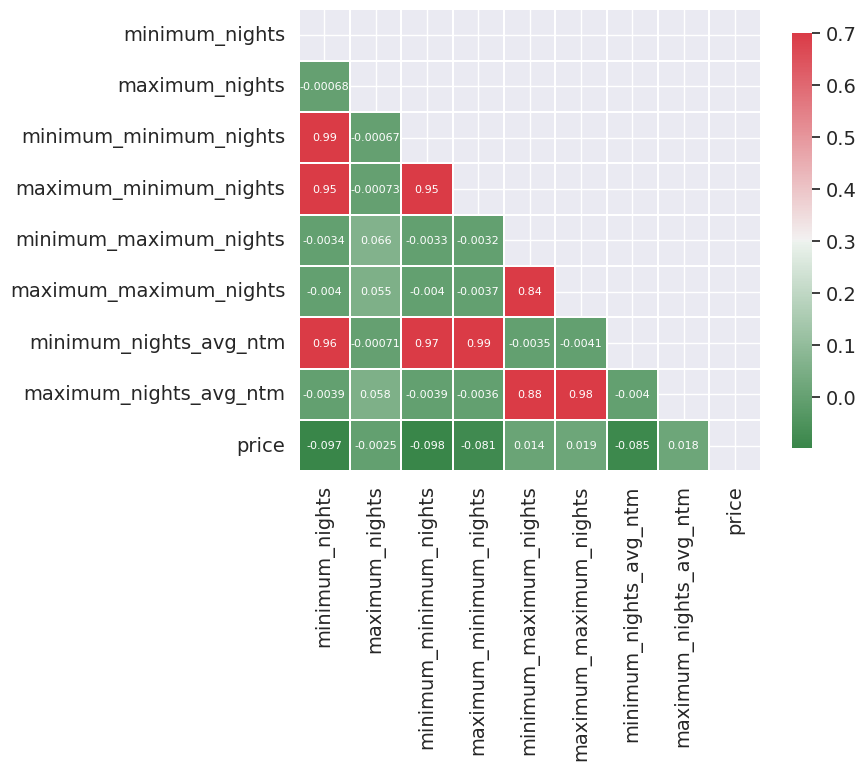

In [43]:
# Correlation between the period of stay and price
mask = np.zeros_like(airbnb_pd[period_stay_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[period_stay_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

Some of the features are similar to each other but none of them is actually helpful for determining the price so we can remove them all. For the moment we only leave the minimum_nights features that shows the highest correlation:

In [44]:
# Remove some columns
airbnb_df = airbnb_df.drop('maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm')

Now, let's evaluate the features concerning the availability. There are some features describing how much time the Airbnb is available (e.g. how many days in a month, one many days in three months, how many days in a year, etc..). Let's see it is someway linked to the price:

In [45]:
# List the features that describe the minimum/maximum period of stay
availability_features = ['has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'price']

<Axes: >

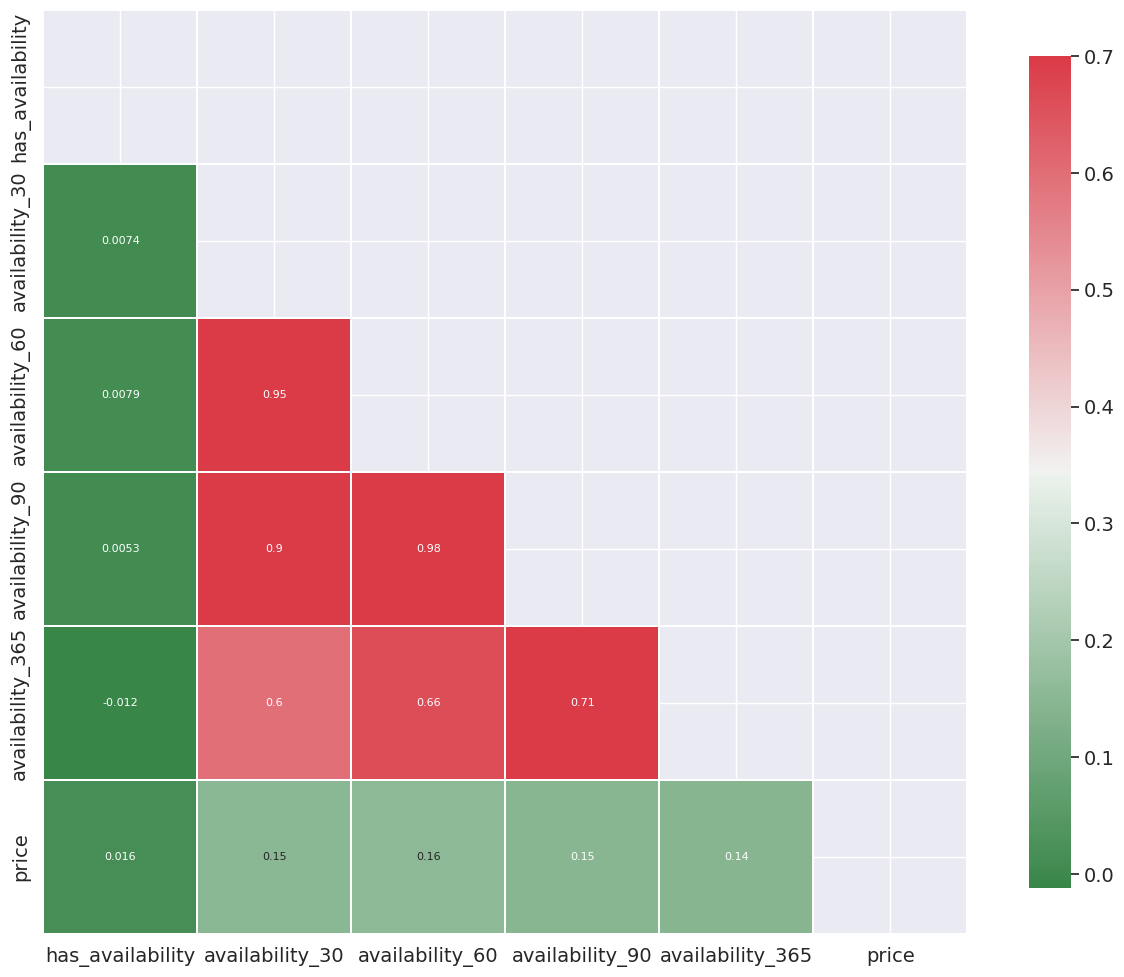

In [46]:
# Correlation between the availability and price
mask = np.zeros_like(airbnb_pd[availability_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(16, 12))           
sns.heatmap(airbnb_pd[availability_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

It is possible to notice that the price slightly increased as the availability arises. Now except the "has_availability" feature that is completely uncorrelated with the price (we can immediately remove it), the others are more or less correlated with each other. I leave the "availability_365" that is kind of able to represent also the other ones and also "availability_30" that is less correlated with the first and see later if it is convenient to consider them both or not:

In [47]:
# Remove some columns
airbnb_df = airbnb_df.drop('has_availability', 'availability_60', 'availability_90')

Now, let's consider the information regarding the reviews:

In [48]:
# Define review features
review_features = ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'price']

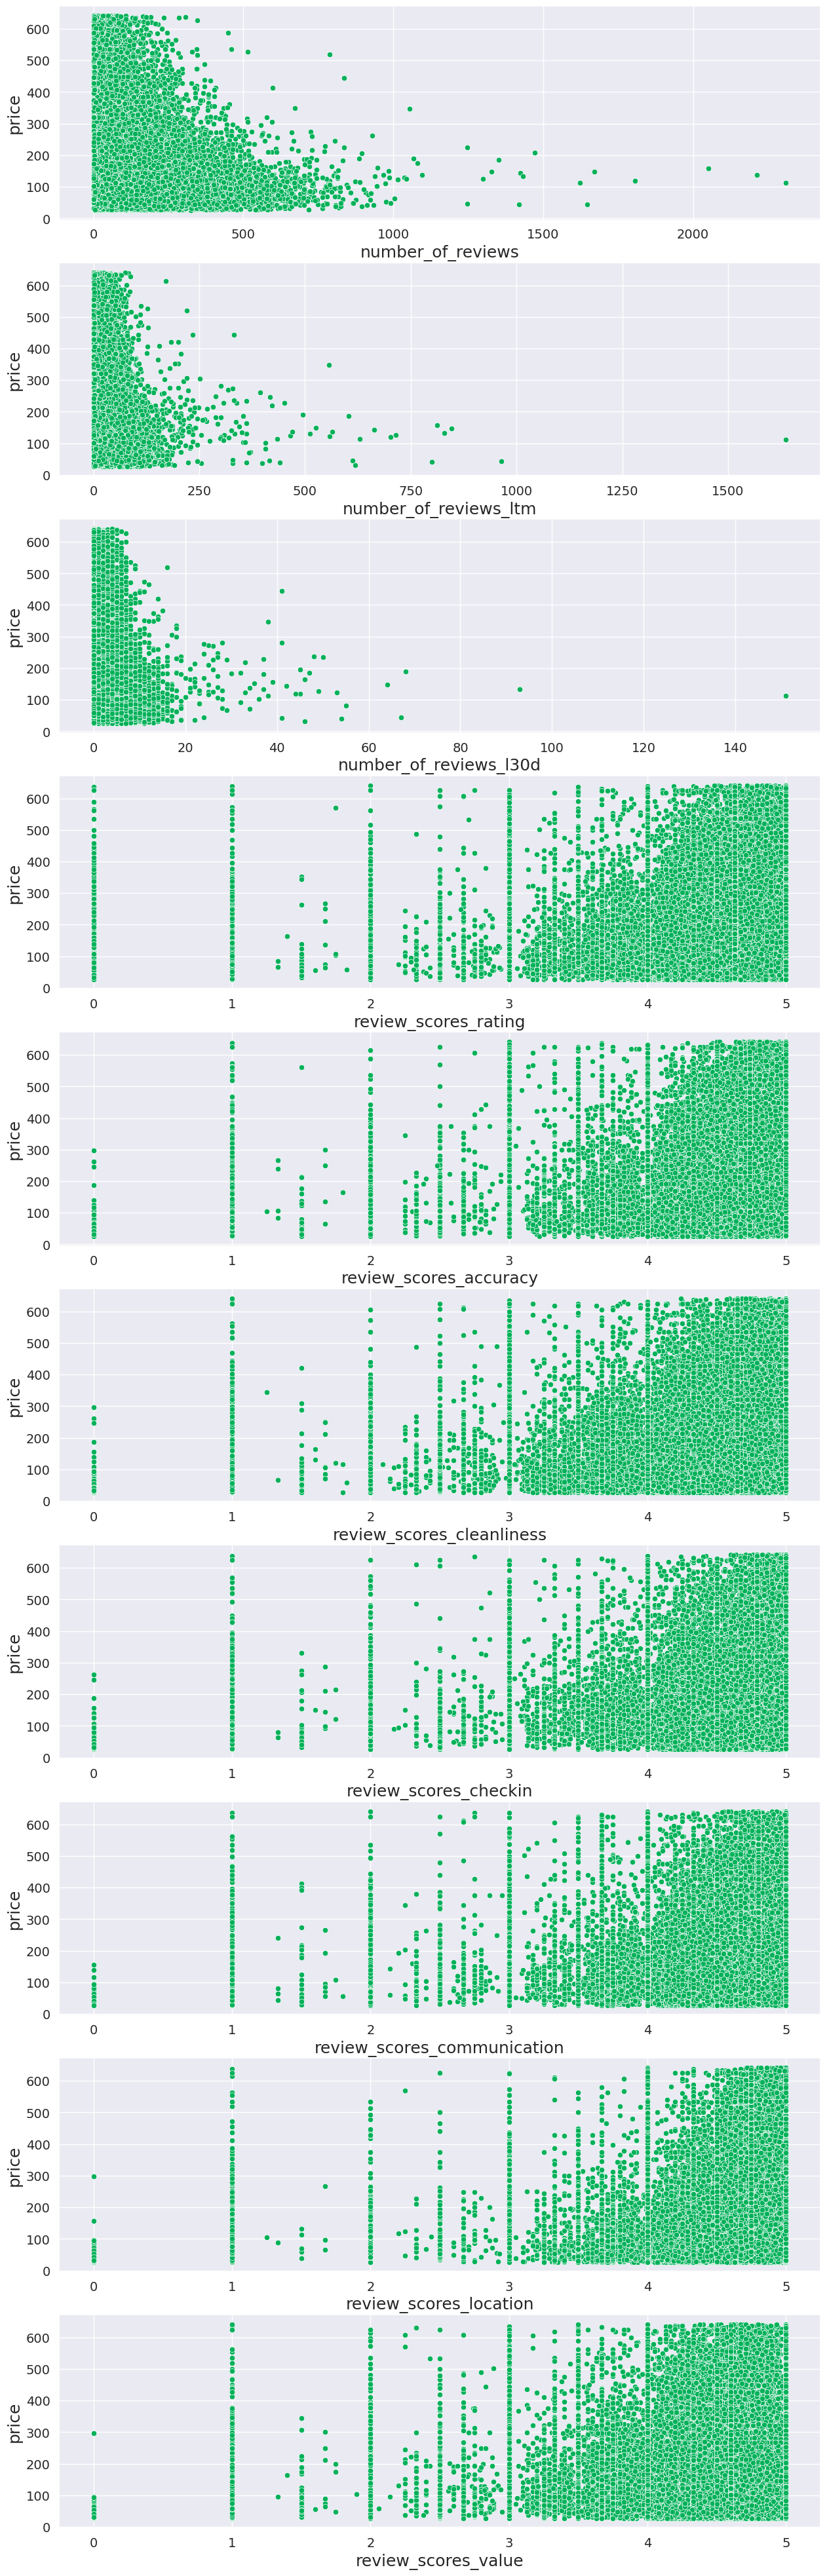

In [49]:
# Visualize the variation of the price depending the reviews of the Airbnb
n_rows = 10
n_cols = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,50))
for i, f in enumerate(review_features[:-1]):
  _ = sns.scatterplot(data = airbnb_pd, x = f, y = 'price', color = '#00b159', ax=axes[i])

<Axes: >

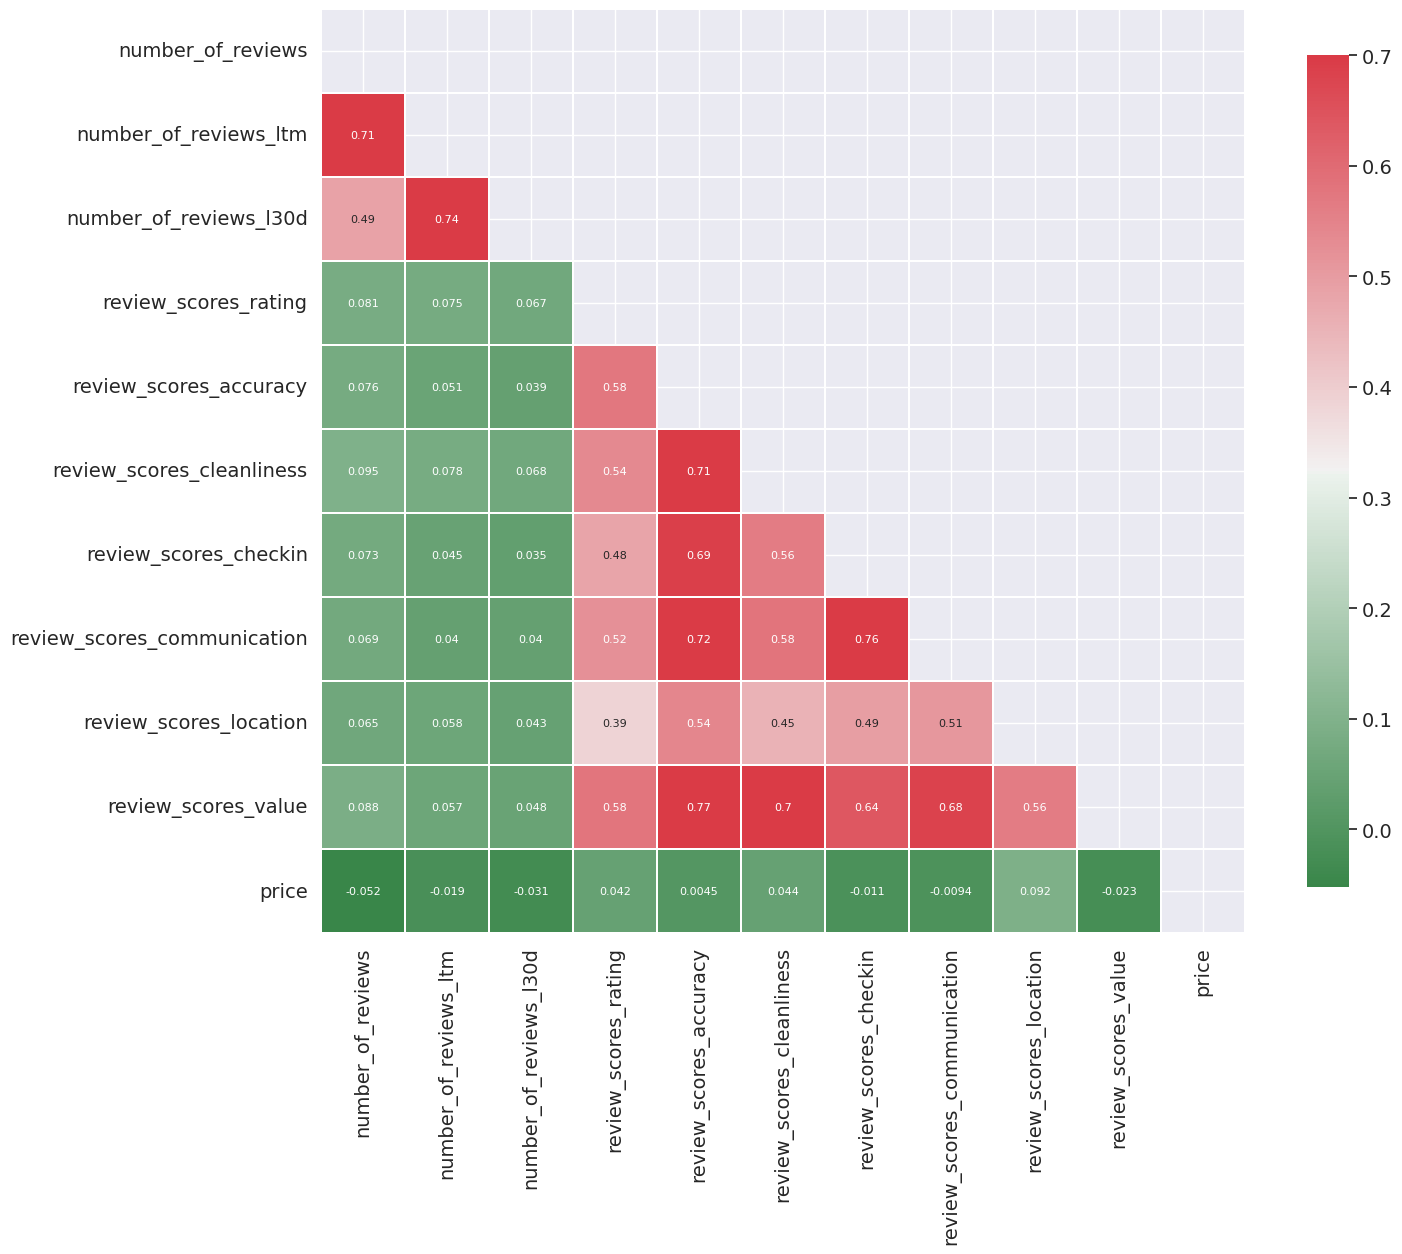

In [50]:
# Correlation between the reviews and price
mask = np.zeros_like(airbnb_pd[review_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(16, 12))           
sns.heatmap(airbnb_pd[review_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

Concerning the number of reviews, it is possible to notice that the Airbnb with a higher price have generally a lower number of reviews. For what concerns the score, we can also notice how the only feature that has a higher correlation is the one related to the location. Now, the location score usually depends on the position of the Airbnb such as the distance to the city center or to a station. Let’s the if there if a correlation between the two:

<Axes: >

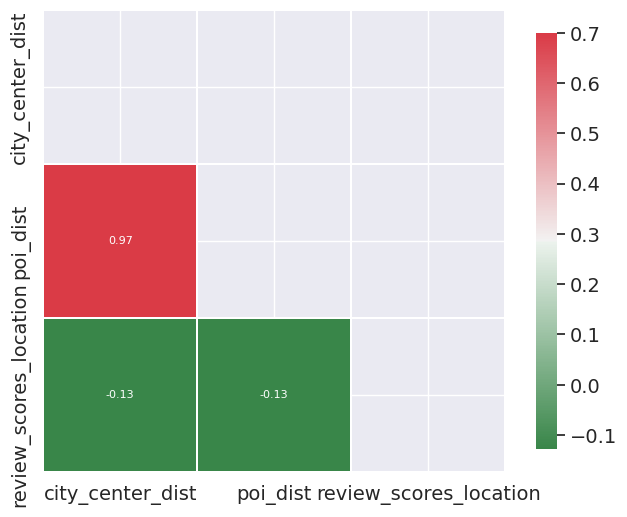

In [51]:
# Correlation between the city center distance and the location score
mask = np.zeros_like(airbnb_pd[['city_center_dist', 'poi_dist', 'review_scores_location']].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[['city_center_dist', 'poi_dist', 'review_scores_location']].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

This graph shows that city center and review based on location have a negative correlation meaning that the location score slightly increases as the distance to city center decreases. They show a little negative correlation but it's not so high. For the moment I remove the various features regarding the number of reviews (except the main one - number_of_reviews) and reviews accuracy and communication that show a really low correlation with the price:

In [52]:
# Remove some columns
airbnb_df = airbnb_df.drop('number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_communication')

Let's see if something changes if the Airbnb is instantly bookable or not:

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

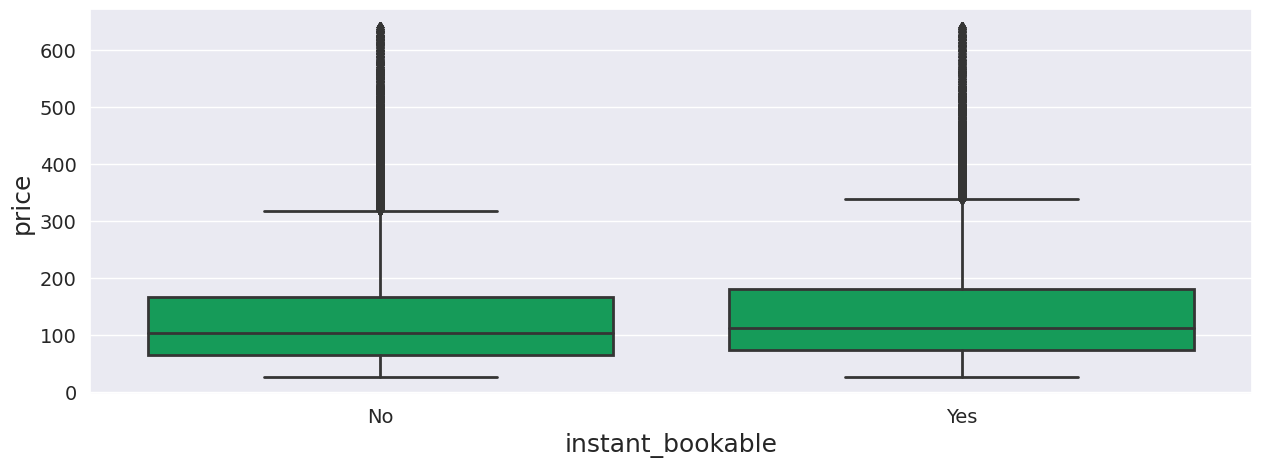

In [53]:
# Visualize the change in price depending if the accommodation is instantly bookable or not
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = 'instant_bookable', y = 'price', color='#00b159', ax=ax1)
ax1.set_xticklabels(['No', 'Yes'])

<Axes: >

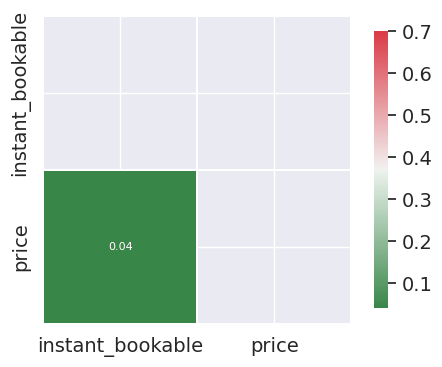

In [54]:
# Correlation between the availability and price
mask = np.zeros_like(airbnb_pd[['instant_bookable', 'price']].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(6, 4))           
sns.heatmap(airbnb_pd[['instant_bookable', 'price']].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

We notice that the price slightly increases if the accommodation is instantly bookable. Again, the correlation is not that high. Now, there are some features regarding the number of the host's listings. let's see if they have an impact on the price:

In [55]:
# Define host listings features
host_listings_features = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'price']

<Axes: >

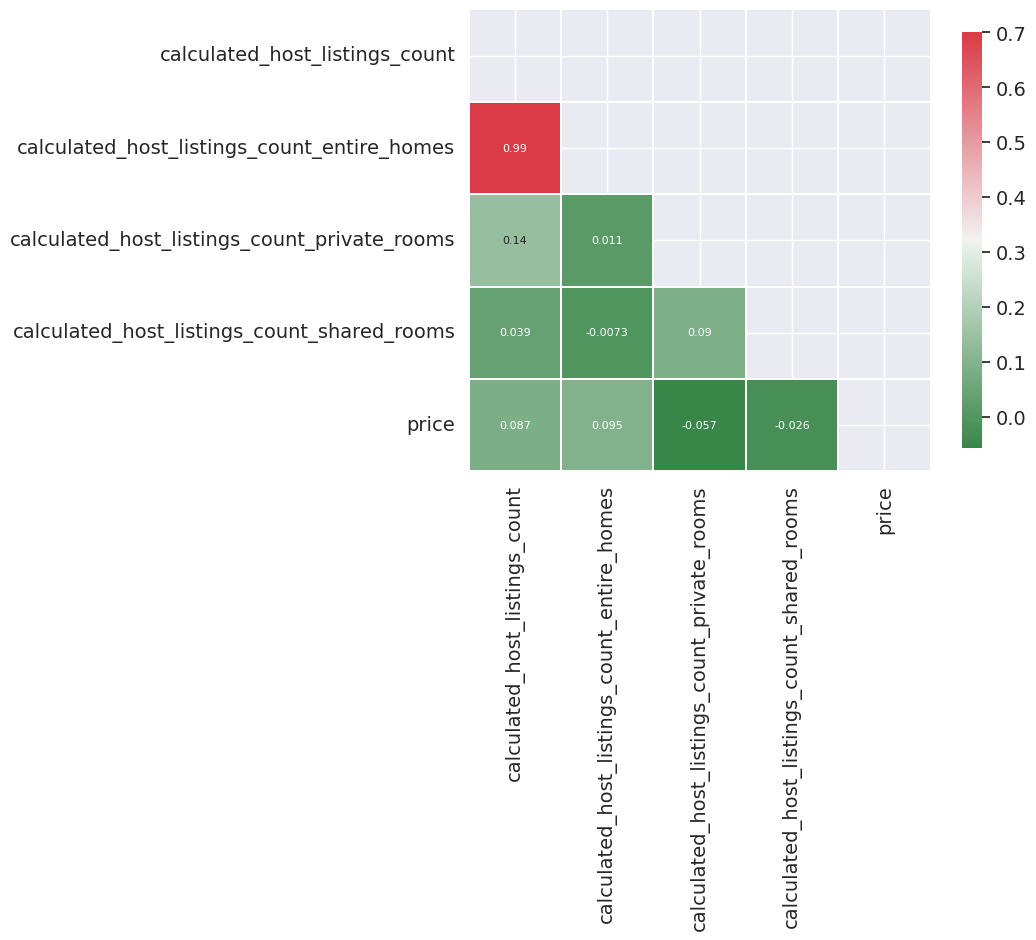

In [56]:
# Correlation between the reviews and price
mask = np.zeros_like(airbnb_pd[host_listings_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[host_listings_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

As we can see, the first two have a discrete positive correlation with the price. They are also highly (99%) correlated so it makes sense to delete one of the two. I only leave the first one (calculated_host_listed_counts) that is kind of able to also represent the other features. Now, before we had another feature ‘host_listings_count’ that represented the number of listings. Let’s see if there is a correlation between the two:

<Axes: >

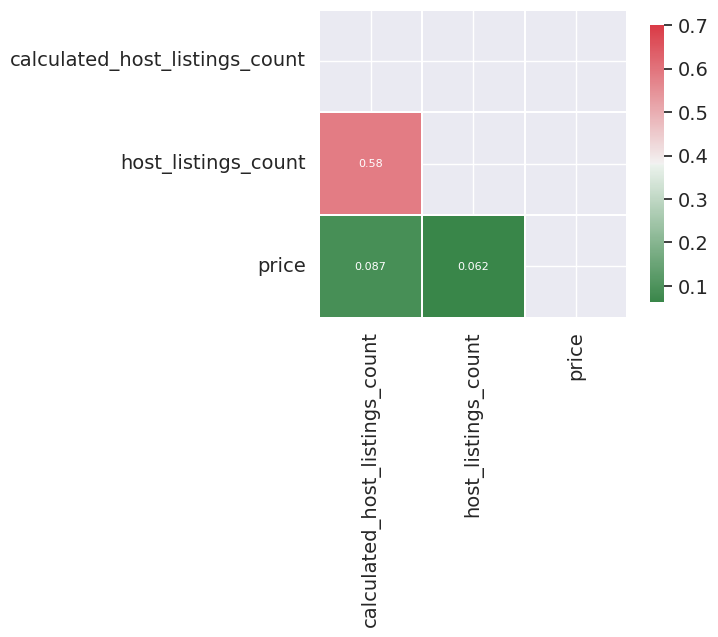

In [57]:
# Correlation between the reviews and price
mask = np.zeros_like(airbnb_pd[['calculated_host_listings_count', 'host_listings_count', 'price']].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(6, 4))           
sns.heatmap(airbnb_pd[['calculated_host_listings_count', 'host_listings_count', 'price']].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

Actually there is a correlation between the two so we only leave the one with the highest positive correlation.

In [58]:
# Drop some columns
airbnb_df = airbnb_df.drop('calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count')

<Axes: ylabel='calculated_host_listings_count'>

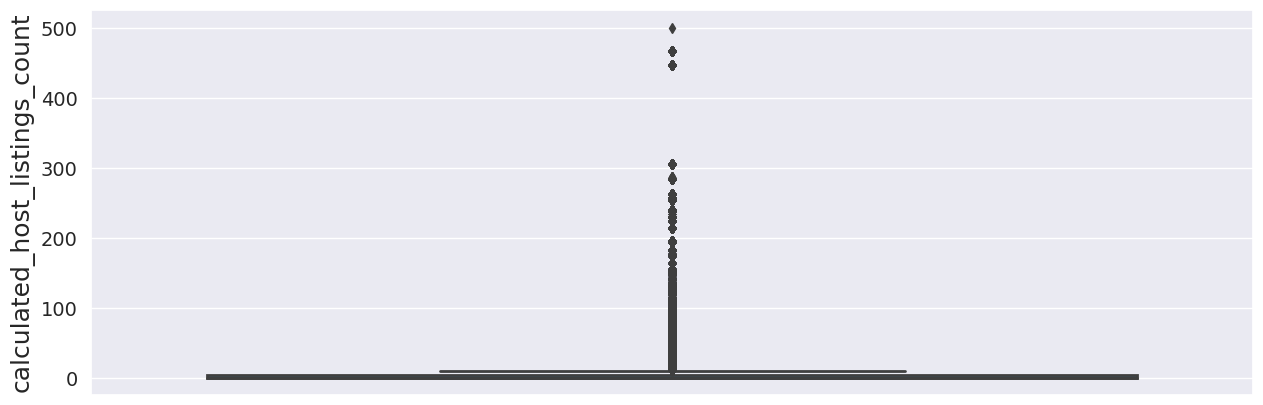

In [59]:
# Outliers analysis for "calculated_host_listings_count"
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, y = 'calculated_host_listings_count', hue = 'price', ax = ax1)

In [60]:
# Print the number of hosts with a calculated listings count higher than a certain value
print("The number of hosts with a calculated listings count higher than than 300: " + str(airbnb_df.select(expr("sum(CASE WHEN calculated_host_listings_count>300 THEN 1 ELSE 0 END)")).collect()[0][0]))

The number of hosts with a calculated listings count higher than than 300: 1179


In [61]:
# Define amenity features
amenity_features = ['has_internet', 'is_pet_friendly', 'is_children_friendly', 'has_cooking_basics', 'has_laundry', 'has_heating_cooling_systems', 'has_security_devices', 'has_fireplace', 'has_tv', 'is_long_term_stays_allowed', 'has_self_checkin', 'has_private_entrance', 'has_elevator', 'host_greets_you', 'has_free_parking', 'has_paid_parking', 'has_bathtub', 'has_patio', 'is_smoking_allowed', 'has_city_skyline_view', 'has_breakfast', 'price']

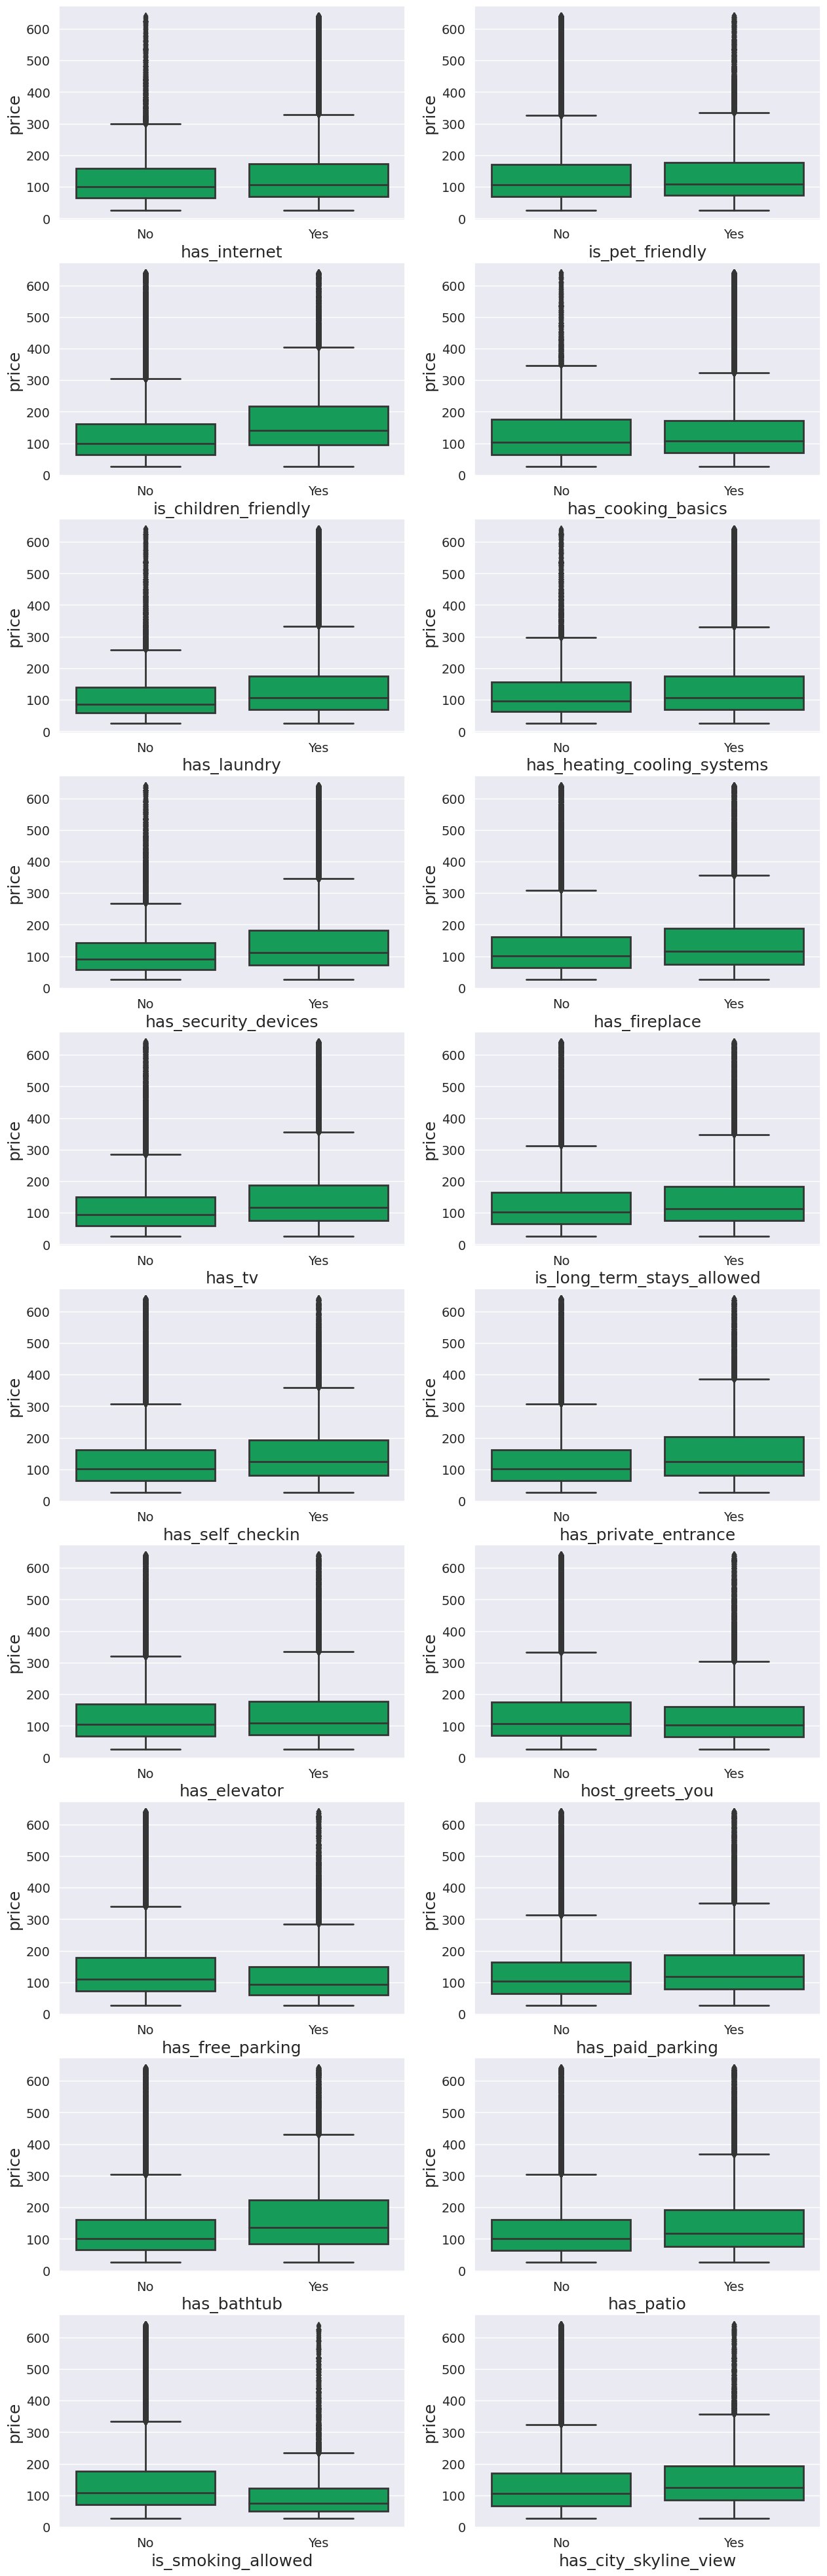

In [62]:
# Visualize the variation of the price depending on the presence of a certain amenity of the Airbnb
n_rows = 10
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,50))
for i, f in enumerate(amenity_features[:-2]):
  _ = sns.boxplot(data = airbnb_pd, x = f, y = "price", color ="#00b159", ax=axes[i//n_cols, i%n_cols])
  axes[i//n_cols, i%n_cols].set_xticklabels(['No', 'Yes'])

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

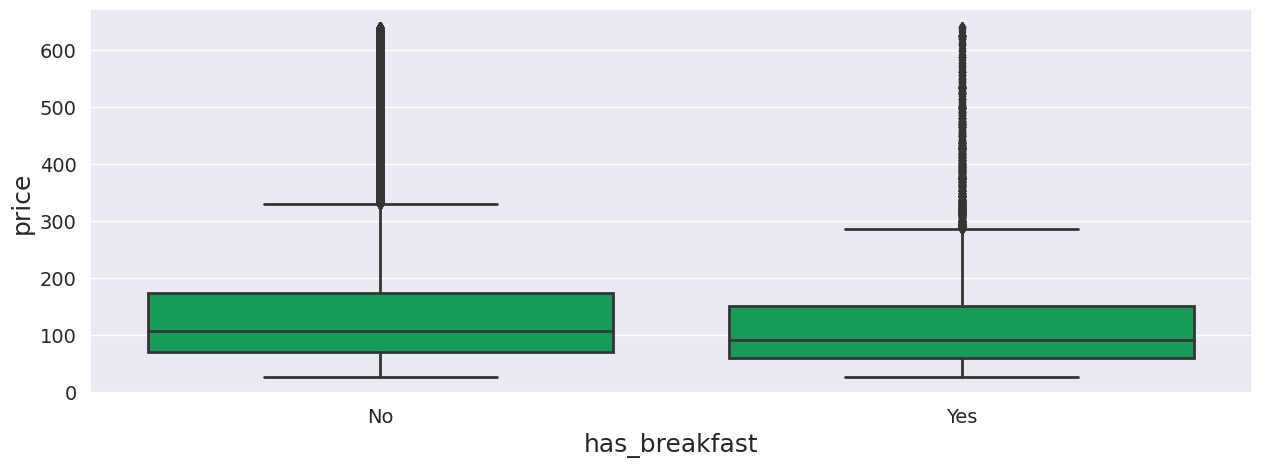

In [63]:
# Visualize the variation of the price depending on the presence of a certain amenity of the Airbnb (breakfast)
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
_ = sns.boxplot(data = airbnb_pd, x = 'has_breakfast', y = 'price', color ='#00b159', ax=ax1)
ax1.set_xticklabels(['No', 'Yes'])

<Axes: >

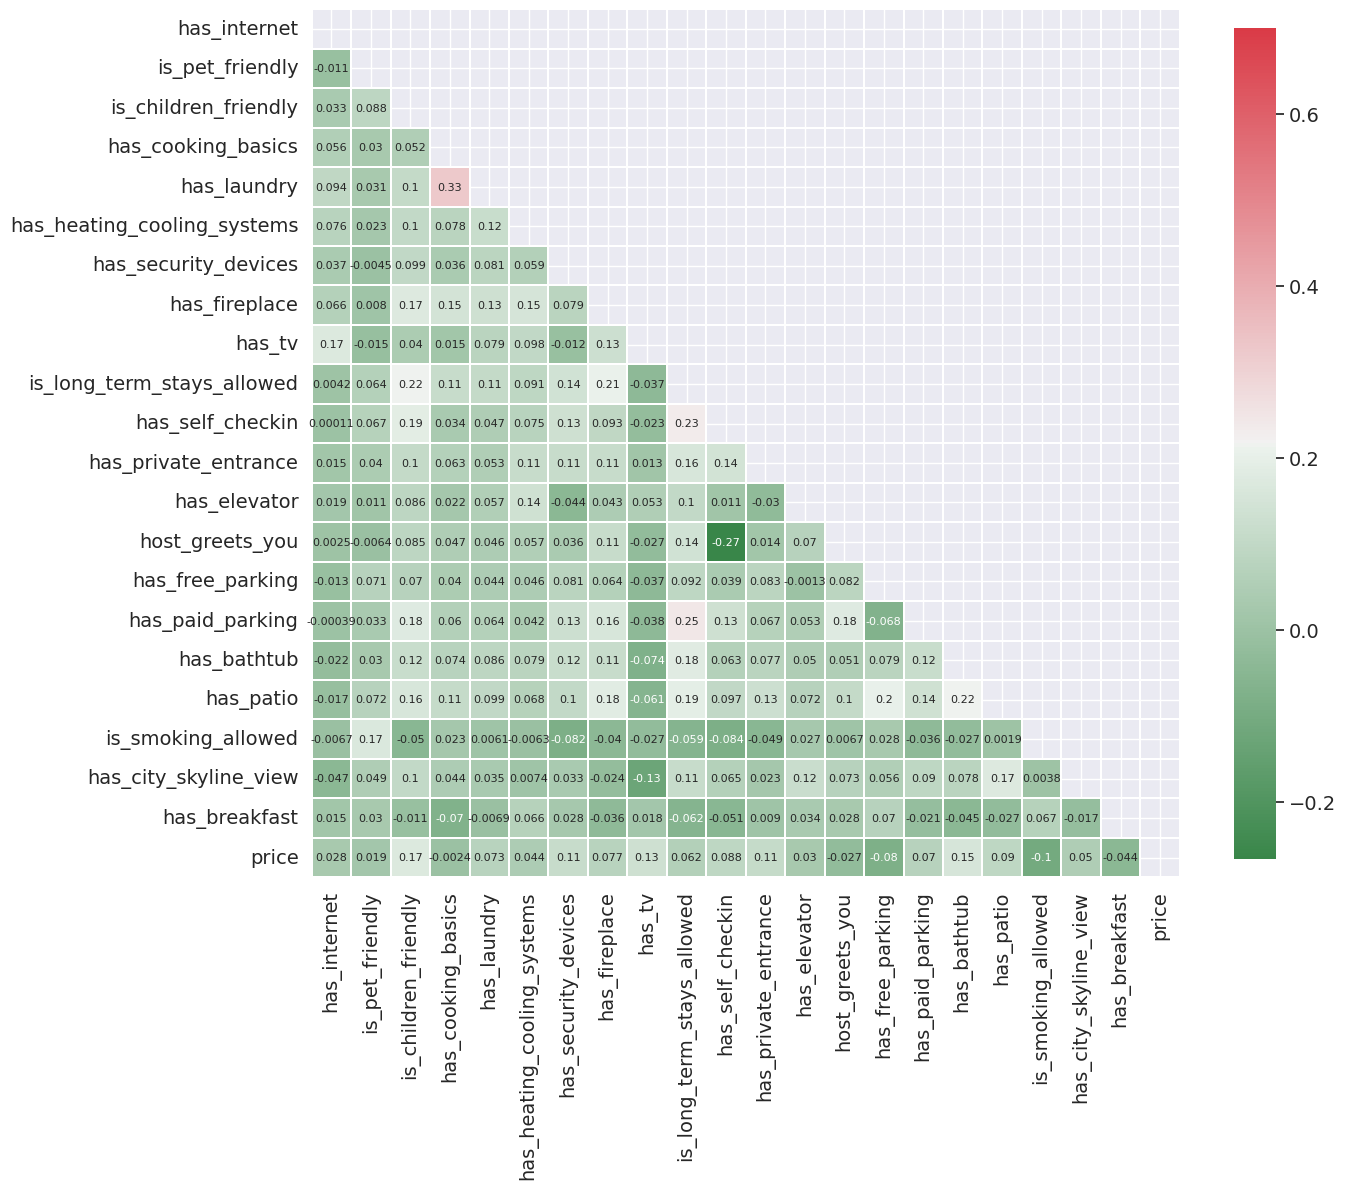

In [64]:
# Correlation between the city center distance and the price
mask = np.zeros_like(airbnb_pd[amenity_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(14, 12))           
sns.heatmap(airbnb_pd[amenity_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

From the graphs above, we can notice some interesting stuff. It is immediate to notice that the presence of an amenity always leads to a slight increase in the price of Airbnb (except a few). The highest increase is given by the fact that Airbnb is children friendly (e.g. there are cribs or security devices for kids). It is also interesting to notice how the price increases if there is at least a TV. Also the fact that Airbnb has a private entrance is a bonus. The presence of a bathtub leads to an increase in the price as well as the presence of different security devices. It is interesting to notice that concerning parking we have a strange behavior. In fact, the presence of private parking leads to a decrease in price while paid parking leads to a higher price (one would think the opposite situation). Also the fact that the host greets you and the breakfast availability doesn't lead to a higher price.

In [65]:
# Reduce the magnitude of some columns
airbnb_df = airbnb_df.withColumn('calculated_host_listings_count', log(airbnb_df['calculated_host_listings_count']))
airbnb_df = airbnb_df.withColumn("number_of_reviews", when(col("number_of_reviews") != 0, log(col("number_of_reviews"))).otherwise(col("number_of_reviews")))

In [66]:
# Print the final cleaned dataset
airbnb_df.show()

+------------------+-----------------+----------------------+----+---------+------------+--------+----+------------------+--------------+-------------------+-------------------+------------------+--------------------+-------------------------+---------------------+----------------------+-------------------+----------------+------------------------------+-----------------+-----------------+----------------------+-----------+------------------+------------+---------------+--------------------+------------------+-----------+---------------------------+--------------------+-------------+------+--------------------------+----------------+--------------------+------------+---------------+----------------+----------------+-----------+---------+------------------+---------------------+-------------+-------------------+------------------+------------------+
|host_response_time|host_is_superhost|host_identity_verified|city|room_type|accommodates|bedrooms|beds|             price|minimum_nights|  



---



Now, we manually analyzed what is the correlation between features and already removed some of them which are not particularly correlated with the price. In order to make a better selection, let’s try some approaches. Let's first of all use a simple Filter-based Feature Selection using PySpark. This is based on Pearson Correlation so we shouldn't have a big difference with the previous approach:

In [67]:
# Assemble the data to apply PySpark methods
assembler = VectorAssembler(inputCols=airbnb_df.columns, outputCol='features')
assembledData = assembler.transform(airbnb_df)

In [68]:
# Compute the correlation matrix
correlationMatrix = Correlation.corr(assembledData, 'features').head()

In [69]:
# Get the highest correlated features
features_correlations = correlationMatrix[0].toArray()
featureNames = airbnb_df.columns
labeledCorrelations = sorted([(featureNames[i], str(features_correlations[i][8])) for i in range(len(featureNames))], key=lambda x: x[1], reverse=True)[1:]

In [70]:
# Print the results
print(labeledCorrelations)

[('accommodates', '0.4832744786793094'), ('bedrooms', '0.43474573270402594'), ('beds', '0.381277992920411'), ('n_bathrooms', '0.2958648993283408'), ('is_children_friendly', '0.19100552469556442'), ('calculated_host_listings_count', '0.16654155982143515'), ('availability_365', '0.16509017005294147'), ('availability_30', '0.16154492362507797'), ('has_tv', '0.15966818384897197'), ('has_bathtub', '0.15486102523433704'), ('has_security_devices', '0.13342082412567816'), ('has_private_entrance', '0.1268152903214946'), ('has_self_checkin', '0.11858695954603325'), ('review_scores_location', '0.10669684965930959'), ('has_patio', '0.10077788575569328'), ('has_paid_parking', '0.09244247192425747'), ('has_fireplace', '0.08843529873725957'), ('has_laundry', '0.08720555742131655'), ('is_work_email_verified', '0.08316954061461433'), ('is_long_term_stays_allowed', '0.07878453826770003'), ('has_city_skyline_view', '0.0644542759842714'), ('instant_bookable', '0.0557772412358346'), ('review_scores_cleanli

Let's see now if something changes using a Random Forest Regressor:

In [71]:
# Split the data for training and testing the model
fs_train_data, fs_test_data = assembledData.randomSplit([0.8, 0.2], seed=42)

In [72]:
# Define and train the model
fs_dt = RandomForestRegressor(featuresCol='features', labelCol='price', numTrees=120, maxDepth=6)
fs_dt_model = fs_dt.fit(fs_train_data)

In [73]:
# Get most important features
dt_feature_importances = fs_dt_model.featureImportances
feature_importances = sorted([(airbnb_df.columns[i], dt_feature_importances[i]) for i in range(len(airbnb_df.columns))], key=lambda x: x[1], reverse=True)[1:]

In [74]:
# Print the importances given by the random tree
for feature, importance in feature_importances:
  print(f"Feature: {feature}, Importance: {importance}")

Feature: bedrooms, Importance: 0.07771282367643804
Feature: accommodates, Importance: 0.04364849759125544
Feature: room_type, Importance: 0.04032788374628983
Feature: is_bathroom_shared, Importance: 0.02993864619372587
Feature: n_bathrooms, Importance: 0.022575941795868797
Feature: city, Importance: 0.015533458753562011
Feature: availability_365, Importance: 0.012611026983074864
Feature: beds, Importance: 0.010846674926697655
Feature: availability_30, Importance: 0.006597459435784396
Feature: minimum_nights, Importance: 0.002328610984102179
Feature: review_scores_location, Importance: 0.0018621713421204298
Feature: calculated_host_listings_count, Importance: 0.0007130291255834231
Feature: city_center_dist, Importance: 0.0006423555605348452
Feature: has_cooking_basics, Importance: 0.0005962584665248102
Feature: number_of_reviews, Importance: 0.0005918574985574334
Feature: poi_dist, Importance: 0.0005754097748869579
Feature: has_bathtub, Importance: 0.0005314061829577568
Feature: has_fre

Both methods highlighted that some features are used more than others. We'll keep that into consideration when training the model.

In [ ]:
# Save the dataset (remove the comment if you want to save the dataset)
#airbnb_df.coalesce(1).write.mode('overwrite').csv(GDRIVE_DATA_DIR + '/airbnb_cleaned_df_price_model.csv')

# 5.2 Training the Model

In order to train the model, we'll try several approaches. First we try to understand what are the features that give the best results, then we try different models to understand what gives the best result while also doing some hyperparameters tuning.

In [ ]:
# Function that create a simple lr model (with no hyperparameter tuning)
def simple_linear_regression_model(train, featureCol, labelCol):
  lr = LinearRegression(featuresCol=featureCol, labelCol=labelCol)
  lr_model = lr.fit(train)
  return lr_model

In [ ]:
# Function that create a simple rf model (with no hyperparameter tuning)
def simple_random_forest_model(train, featureCol, labelCol):
  rf = RandomForestRegressor(featuresCol=featureCol, labelCol=labelCol)
  rf_model = rf.fit(train)
  return rf_model

In [ ]:
# Function that create a simple gbt model (with no hyperparameter tuning)
def simple_gbt_model(train, featureCol, labelCol):
  gbt = GBTRegressor(featuresCol=featureCol, labelCol=labelCol)
  gbt_model = gbt.fit(train)
  return gbt_model

In [ ]:
# Define the evaluation metrics
# Notice that r2_adj metric is included when calculating r2
metrics = ['mse', 'rmse', 'mae', 'r2']

In [ ]:
# Function to compute the r2 adjusted metric
# r2 is the r2 metric, n is the number of observations, k is the number of features
def compute_r2adj(r2, n, k):
  return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

In [ ]:
# Function to evaluate a model
def evaluate_models(predictions, modelName, typeName, label, prediction, metrics):
  r2 = None
  for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=label, predictionCol=prediction, metricName=metric) 
    evaluation = evaluator.evaluate(predictions)
    print(metric.upper()+' for '+modelName+' on '+typeName+' set: '+str(evaluation))
    if metric == 'r2':
      print('R2_adj'+' for '+modelName+' on '+typeName+' set: '+str(compute_r2adj(evaluation, predictions.count(), len(predictions.columns))))

In [ ]:
# Function that create simple models (without hyperparameter tuning) and evaluate them
def test_best_features(df, features, featureCol, labelCol, metrics = ['rmse', 'r2']):
  assembler = VectorAssembler(inputCols=features, outputCol=featureCol)
  assembled_data = assembler.transform(df).select([featureCol, labelCol])
  train_data, test_data = assembled_data.randomSplit([0.80, 0.20], seed=42)

  # Train the models
  lr = simple_linear_regression_model(train_data, featureCol, labelCol)
  rf = simple_random_forest_model(train_data, featureCol, labelCol)
  gbt = simple_gbt_model(train_data, featureCol, labelCol)

  # Training set evaluation
  lr_training = lr.transform(train_data)
  evaluate_models(lr_training, 'linear regression', 'training', labelCol, 'prediction', metrics)
  rf_training = rf.transform(test_data)
  evaluate_models(rf_training, 'random forest regression', 'training', labelCol, 'prediction', metrics)
  gbt_training = gbt.transform(train_data)
  evaluate_models(gbt_training, 'gradient boosted tree regression', 'training', labelCol, 'prediction', metrics)

  # Testing set evaluation
  lr_predictions = lr.transform(test_data)
  evaluate_models(lr_predictions, 'linear regression', 'testing', labelCol, 'prediction', metrics)
  rf_predictions = rf.transform(test_data)
  evaluate_models(rf_predictions, 'random forest regression', 'testing', labelCol, 'prediction', metrics)
  gbt_predictions = gbt.transform(test_data)
  evaluate_models(gbt_predictions, 'gradient boosted tree regression', 'testing', labelCol, 'prediction', metrics)

Let's see what features give the best results based on the information we got so far. I train some simple model (without hyperparameter tuning) to see what are the results with different splits:

In [ ]:
# Consider all relevant features (high positive or negative correlation)
most_relevant_features = ['accommodates', 'bedrooms', 'beds', 'n_bathrooms', 'is_children_friendly', 'availability_365', 'has_tv', 'is_bathroom_shared', 'room_type']

In [ ]:
# Test performances with the most relevant features
test_best_features(airbnb_df, most_relevant_features, 'features', 'price')

RMSE for linear regression on training set: 0.5384115560793715
R2 for linear regression on training set: 0.33731893574563643
R2_adj for linear regression on training set: 0.33731009630519115
RMSE for random forest regression on training set: 0.5242437280288311
R2 for random forest regression on training set: 0.37301594335822463
R2_adj for random forest regression on training set: 0.37298280991972965
RMSE for gradient boosted tree regression on training set: 0.5136072799600017
R2 for gradient boosted tree regression on training set: 0.3969710565446658
R2_adj for gradient boosted tree regression on training set: 0.3969630127982545
RMSE for linear regression on testing set: 0.5395490669198877
R2 for linear regression on testing set: 0.3358718291930365
R2_adj for linear regression on testing set: 0.33583673284622007
RMSE for random forest regression on testing set: 0.5242437280288311
R2 for random forest regression on testing set: 0.37301594335822463
R2_adj for random forest regression on 

In [ ]:
# Consider less relevant features (medium positive or negative correlation)
# Here I consider POI distance instead of city center distance (they are highly correlated so I choose only one of the two)
mid_relevant_features = ['accommodates', 'bedrooms', 'n_bathrooms', 'is_children_friendly', 'availability_365', 'has_tv', 'is_bathroom_shared', 'room_type', 'has_bathtub', 'has_self_checkin', 'has_private_entrance', 'has_security_devices', 'calculated_host_listings_count', 'has_patio', 'is_smoking_allowed', 'poi_dist', 'has_free_parking', 'host_identity_verified', 'station_dist', 'review_scores_cleanliness', 'host_is_superhost', 'instant_bookable', 'host_response_time', 'has_elevator', 'review_scores_rating', 'review_scores_location', 'has_cooking_basics', 'number_of_reviews', 'city', 'has_paid_parking', 'minimum_nights']

In [ ]:
# Test features with the less relevant features 
test_best_features(airbnb_df, mid_relevant_features, 'features', 'price')

RMSE for linear regression on training set: 0.49730379309274364
R2 for linear regression on training set: 0.4341507717222043
R2_adj for linear regression on training set: 0.43414322391252
RMSE for random forest regression on training set: 0.48215943717745136
R2 for random forest regression on training set: 0.4714832156151898
R2_adj for random forest regression on training set: 0.47145528575288553
RMSE for gradient boosted tree regression on training set: 0.4237332974278131
R2 for gradient boosted tree regression on training set: 0.589188710635656
R2_adj for gradient boosted tree regression on training set: 0.5891832308624703
RMSE for linear regression on testing set: 0.4966478864859573
R2 for linear regression on testing set: 0.43924310250647847
R2_adj for linear regression on testing set: 0.43921346889143364
RMSE for random forest regression on testing set: 0.48215943717745136
R2 for random forest regression on testing set: 0.4714832156151898
R2_adj for random forest regression on tes

In [ ]:
# Consider all features (except the ones we removed before)
all_features = airbnb_df.drop('price').columns

In [ ]:
# Test performances with all features
test_best_features(airbnb_df, all_features, 'features', 'price')

RMSE for linear regression on training set: 0.4837460321987904
R2 for linear regression on training set: 0.46395369593602587
R2_adj for linear regression on training set: 0.46394654566474713
RMSE for random forest regression on training set: 0.4895849377566864
R2 for random forest regression on training set: 0.45758647093454174
R2_adj for random forest regression on training set: 0.4575578066884357
RMSE for gradient boosted tree regression on training set: 0.41547023846735787
R2 for gradient boosted tree regression on training set: 0.6045903056644985
R2_adj for gradient boosted tree regression on training set: 0.6045850313317416
RMSE for linear regression on testing set: 0.4863616556231798
R2 for linear regression on testing set: 0.4647051397809413
R2_adj for linear regression on testing set: 0.46467685172618156
RMSE for random forest regression on testing set: 0.4895849377566864
R2 for random forest regression on testing set: 0.45758647093454174
R2_adj for random forest regression on 

For the tests done so far, it is possible to see how the model underfits with considering only the most important features, in fact the R2 scores on both the training set and testing set are low. With a higher number of features the performance increases. A reason might be that we have a lot of data, so a higher complexity is needed to reach better results. Also, what we noticed so far is that there are no features that really help determine the price of an Airbnb because all of them have a low correlation with the price. We saw that the position and the size of the accommodation are good ways to guess the price of an Airbnb, but in the end, it is the owner that decides the price, but for this reason we will never reach a perfect prediction. What we can do is try to reach the lowest error possible. Finally, if we consider all features, performance doesn't change too much so it might be better to select the second group. So, let's try to do some hyperparameter tuning to choose the best hyperparameters:

In [ ]:
# Let's again split the data (here we also use validation data to find the best hyperparameters)
assembler = VectorAssembler(inputCols=mid_relevant_features, outputCol='features')
assembled_data = assembler.transform(airbnb_df).select(['features', 'price'])
train_data, test_data, validation_data = assembled_data.randomSplit([0.80, 0.15, 0.05], seed=42)

In [ ]:
# Hyperparameter tuning for linear regression
def linear_regression_cross_val(train, k_fold=5):
    lr = LinearRegression(featuresCol='features', labelCol='price')
    pipeline = Pipeline(stages=[lr])

    param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(labelCol='price'),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
# Execute cross validation with linear regression
cv_lr_models = linear_regression_cross_val(validation_data)

In [ ]:
# Summarizes all the models trained during k-fold cross validation
def summarize_lr_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above|
summarize_lr_models(cv_lr_models.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_b10d1437c77d, numFeatures=31

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_b10d1437c77d, numFeatures=31

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_b10d1437c77d, numFeatures=31

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_b10d1437c77d, numFeatures=31

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_b10d1437c77d, numFeatures=31

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_b10d1437c77d, numFeatures=31


In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_lr_models.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.501499
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.501499
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.501499
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.501788
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.513368
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.535046
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.502732
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.536805
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.568902


In [ ]:
# Get best model and evaluate it
best_lr_model_params = cv_lr_models.bestModel.stages[-1].extractParamMap()
print("Best parameters for linear regression:")
for param, value in best_lr_model_params.items():
    print(param.name, "=", value)

Best parameters for linear regression:
aggregationDepth = 2
elasticNetParam = 0.0
epsilon = 1.35
featuresCol = features
fitIntercept = True
labelCol = price
loss = squaredError
maxBlockSizeInMB = 0.0
maxIter = 100
predictionCol = prediction
regParam = 0.0
solver = auto
standardization = True
tol = 1e-06


In [ ]:
# Fit a model with best parameters
lr = LinearRegression(featuresCol='features', labelCol='price', elasticNetParam=0, regParam=0, maxIter=1000)
lr_model = lr.fit(train_data)

In [ ]:
# Training set evaluation
lr_training = lr_model.transform(train_data)
evaluate_models(lr_training, 'linear regression', 'training', 'price', 'prediction', metrics)

# Testing set evaluation
lr_predictions = lr_model.transform(test_data)
evaluate_models(lr_predictions, 'linear regression', 'testing', 'price', 'prediction', metrics)

MSE for linear regression on training set: 0.24646070799188008
RMSE for linear regression on training set: 0.49644809194102063
MAE for linear regression on training set: 0.3873444914908169
R2 for linear regression on training set: 0.4360307324880086
R2_adj for linear regression on training set: 0.43602322391035564
MSE for linear regression on testing set: 0.2498254351155321
RMSE for linear regression on testing set: 0.49982540463198954
MAE for linear regression on testing set: 0.3899726515939456
R2 for linear regression on testing set: 0.43255128549239363
R2_adj for linear regression on testing set: 0.4325109703750838


In [ ]:
# Save the LR best model
lr_model.write().overwrite().save(GDRIVE_DATA_DIR + '/models/price/LinearRegressor')



---



In [ ]:
# This function defines the general pipeline for random forest regressor
def rf_cross_val(train, k_fold=5):
    rf = RandomForestRegressor(featuresCol='features', labelCol='price')
    pipeline = Pipeline(stages=[rf])

    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [8, 9, 10]) \
    .addGrid(rf.numTrees, [40, 60, 80]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(labelCol='price'),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
# Execute cross validation with random forest regressor (high RAM usage!)
cv_rf_models = rf_cross_val(validation_data)

In [ ]:
# Summarizes all the models trained during k-fold cross validation
def summarize_rf_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDepth=[{:.3f}]; numTrees=[{:.3f}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getNumTrees()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above|
summarize_rf_models(cv_rf_models.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: maxDepth=[8.000]; numTrees=[40.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_badce02951de, numTrees=40, numFeatures=31

--- Model #2 out of 9 ---
	Parameters: maxDepth=[8.000]; numTrees=[60.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_badce02951de, numTrees=60, numFeatures=31

--- Model #3 out of 9 ---
	Parameters: maxDepth=[8.000]; numTrees=[80.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_badce02951de, numTrees=80, numFeatures=31

--- Model #4 out of 9 ---
	Parameters: maxDepth=[9.000]; numTrees=[40.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_badce02951de, numTrees=40, numFeatures=31

--- Model #5 out of 9 ---
	Parameters: maxDepth=[9.000]; numTrees=[60.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_badce02951de, numTrees=60, numFeatures=31

--- Model

In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_rf_models.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.446910
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.444623
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.444307
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.437913
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.435403
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.435452
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.431146
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.428533
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.428453


In [ ]:
# Get best model and evaluate it
best_rf_model_params = cv_rf_models.bestModel.stages[-1].extractParamMap()
print('Best parameters for random forest regressor:')
for param, value in best_rf_model_params.items():
    print(param.name, "=", value)

Best parameters for random forest regressor:
bootstrap = True
cacheNodeIds = False
checkpointInterval = 10
featureSubsetStrategy = auto
featuresCol = features
impurity = variance
labelCol = price
leafCol = 
maxBins = 32
maxDepth = 10
maxMemoryInMB = 256
minInfoGain = 0.0
minInstancesPerNode = 1
minWeightFractionPerNode = 0.0
numTrees = 80
predictionCol = prediction
seed = -9210051078898526106
subsamplingRate = 1.0


In [ ]:
# Fit a model with best parameters
rf = RandomForestRegressor(featuresCol='features', labelCol='price', maxDepth=10, numTrees=80)
rf_model = rf.fit(validation_data)

In [ ]:
# Training set evaluation
rf_training = rf_model.transform(train_data)
evaluate_models(rf_training, 'random forest regressor', 'training', 'price', 'prediction', metrics)

# Testing set evaluation
rf_predictions = rf_model.transform(test_data)
evaluate_models(rf_predictions, 'random forest regressor', 'testing', 'price', 'prediction', metrics)

MSE for random forest regressor on training set: 0.18574261851608875
RMSE for random forest regressor on training set: 0.4309786752451782
MAE for random forest regressor on training set: 0.3327328946278369
R2 for random forest regressor on training set: 0.5750197494996999
R2_adj for random forest regressor on training set: 0.575014080728073
MSE for random forest regressor on testing set: 0.18492630218749198
RMSE for random forest regressor on testing set: 0.43003058285137347
MAE for random forest regressor on testing set: 0.3321758293935531
R2 for random forest regressor on testing set: 0.5807815684757687
R2_adj for random forest regressor on testing set: 0.5807518577435558


In [ ]:
# Save the RF best model
rf_model.write().overwrite().save(GDRIVE_DATA_DIR + '/models/price/RandomForest')



---



In [ ]:
# This function defines the general pipeline for gradient-boosted trees
def gbt_cross_val(train, k_fold=5):
    gbt = GBTRegressor(featuresCol='features', labelCol='price')
    pipeline = Pipeline(stages=[gbt])

    param_grid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [6, 7, 8]) \
    .addGrid(gbt.maxIter, [11, 12, 13]) \
    .addGrid(gbt.stepSize, [0.15, 0.2, 0.25]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(labelCol="price"),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
# Execute cross validation with gradient-boosted trees
cv_gbt_models = gbt_cross_val(validation_data)

In [ ]:
# Summarizes all the models trained during k-fold cross validation
def summarize_gbt_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDepth=[{:.3f}]; maxIter=[{:.3f}; stepSize=[{:.3f}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getMaxIter(), m.stages[-1]._java_obj.getStepSize()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above maxDepth=7, maxIter=13, stepSize=0.25
summarize_gbt_models(cv_gbt_models.subModels)

*************** Fold #1 ***************

--- Model #1 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.150] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_29ce986ba504, numTrees=11, numFeatures=31

--- Model #2 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.200] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_29ce986ba504, numTrees=11, numFeatures=31

--- Model #3 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.250] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_29ce986ba504, numTrees=11, numFeatures=31

--- Model #4 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[12.000; stepSize=[0.150] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_29ce986ba504, numTrees=12, numFeatures=31

--- Model #5 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[12.000; stepSize=[0.200] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_29ce986ba504, numTrees=12, numFeatures=31

--- Model #6 o

In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_gbt_models.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.434844
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.430433
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.434561
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.432873
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.429622
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.431940
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.431117
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.428261
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.430738
Avg. RMSE computed across k-fold cross validation for model setting #10: 0.441840
Avg. RMSE computed across k-fold cross validation for model setting #11: 0.440595
Avg. RMSE computed across k-fold cross validation for model setting #12: 0.444434
Avg. RMSE computed across

In [ ]:
# Get best model and evaluate it
best_gbt_model_params = cv_gbt_models.bestModel.stages[-1].extractParamMap()
print("Best parameters for gradient-boosted trees:")
for param, value in best_gbt_model_params.items():
    print(param.name, "=", value)

Best parameters for gradient-boosted trees:
cacheNodeIds = False
checkpointInterval = 10
featureSubsetStrategy = all
featuresCol = features
impurity = variance
labelCol = price
leafCol = 
lossType = squared
maxBins = 32
maxDepth = 6
maxIter = 13
maxMemoryInMB = 256
minInfoGain = 0.0
minInstancesPerNode = 1
minWeightFractionPerNode = 0.0
predictionCol = prediction
seed = -7454223888317409867
stepSize = 0.2
subsamplingRate = 1.0
validationTol = 0.01


In [ ]:
# Fit a model with best parameters
gbt = GBTRegressor(featuresCol='features', labelCol='price', maxDepth=6, maxIter=13, stepSize=0.2)
gbt_model = gbt.fit(train_data)

In [ ]:
# Training set evaluation
gbt_training = gbt_model.transform(train_data)
evaluate_models(gbt_training, 'gradient-boosted tree regressor', 'training', 'price', 'prediction', metrics)

# Testing set evaluation
gbt_predictions = gbt_model.transform(test_data)
evaluate_models(gbt_predictions, 'gradient-boosted tree regressor', 'testing', 'price', 'prediction', metrics)

MSE for gradient-boosted tree regressor on training set: 0.15446737792813656
RMSE for gradient-boosted tree regressor on training set: 0.39302338089245603
MAE for gradient-boosted tree regressor on training set: 0.3000783912817505
R2 for gradient-boosted tree regressor on training set: 0.6465776918056215
R2_adj for gradient-boosted tree regressor on training set: 0.6465729775386629
MSE for gradient-boosted tree regressor on testing set: 0.16046163530958224
RMSE for gradient-boosted tree regressor on testing set: 0.40057662851142756
MAE for gradient-boosted tree regressor on testing set: 0.3053352055527062
R2 for gradient-boosted tree regressor on testing set: 0.6362417120843388
R2_adj for gradient-boosted tree regressor on testing set: 0.6362159319080158


During the cross validation step, we selected the hyperparameters that enabled us to reach the best results. The gradient boosted tree regression model is the model that allowed to achieve the lowest error rate (RMSE of 0.40 - remember that price is expressed as log(price)) and a R2 score of about 0.64. Again, as we already stated before, there are no features that are really correlated with the price. The only features that actually count are the one related to the location, the size of the accommodation and some amenities. These features alone are not enough to make a decent prediction so also the other features (the ones which are less correlated) are necessary to sharpen the final prediction and increase the model complexity. Price is not easy to predict since it depends on many things and, in the end, it's a human decision (a host could practically choose the price that he wants) so we will never reach a good prediction score. At the same time, it is not necessary to get an extremely precise result since I just need a price range so that the host can have an idea of ​​the price per night to choose based on the characteristics of his accommodation. An example of use is shown in the web application that will be created and attached to this notebook.

In [ ]:
# Save the GBT best model for further use (we'll use this one in the real scenario tests)
gbt_model.write().overwrite().save(GDRIVE_DATA_DIR + '/models/price/GradientBoostedRegressor')